LSTM Basics
- https://python-bloggers.com/2021/01/predict-stock-prices-with-lstm/
- https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

Find this Book
- https://machinelearningmastery.com/deep-learning-for-time-series-forecasting/

Deep reinforcement Learning:
- https://towardsdatascience.com/deep-reinforcement-learning-for-automated-stock-trading-f1dad0126a02

Financial Turbulence Measurment
- https://www.top1000funds.com/wp-content/uploads/2010/11/FAJskulls.pdf

DirectML https://docs.microsoft.com/en-us/windows/ai/directml/gpu-tensorflow-windows

Framework - 

Model Testing and Evaluation

Automate Hyper parameter tuning

Can we look at sector predictions\

Look at relationship between sectors and individusal stocks

Start with model evaluation

In [1]:
#//*************************************************************************
#//*** Downloads Stock Data and converts the returns to a dataframe,
#//*** which saves a compressed CSV file in the stocks folder
#//*************************************************************************
import json
import requests
import time
import pandas as pd
import platform
import csv
import numpy as np
import playsound
from IPython.display import clear_output

from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from matplotlib import pyplot as plt


sound_filename = "sms-alert-4-daniel_simon.mp3"
#playsound.playsound(sound_filename)

#//*********************************************************************************
#//*** Read the API keys from a JSON encoded file
#//*** Located in the ignore_folder sub directory
#//*** This Folder is added to the .gitignore file and does not show up on Github
#//*** This is Authentication Best Practices for Github
#//*********************************************************************************
f = open("./ignore_folder/alpha_vantage_api.json", "r")

#//*** Fugley Pythonic type conversion
#//*** Loads the file into Dictionary via JSON.loads
#//*** Gets the API key value using the 'api' key
#//*** prepends apikey= so the resulting value is URL ready :]
av_apikey = json.loads(f.read())['apikey']
f.close()

#//*** Load the Stock Tickers
f = open(".\\data\\stock_tickers_ape.json", "r")
symbols = json.loads(f.read())['symbols']

#//*** Just get amc for testing
#symbols = [ "bb" ]

symbols = ['ATOS','SPY','NVCN','CTXR','ACST','DNN','AMD','SPRT','TDA','SENS','IMTE','GSAT','GNUS','AL','XELA','ZOM','WPRT','WHLR','TY','TTOO','TNXP','TBLT','SWI','SQBG','SNMP','RS','TSLA','RGLS','POWW','OIL','OI','OCGN','NRBO','NOC','NET','MVIS','MU','MSM','MSFT','MRNA','MMT','MIK','METX','LODE','LMT','IQ','IBKR','HGEN','GORO','GL','GE','FUV','FSR','CORT','CLOV','CFMS','CEI','BYSI','BTG','BNGO','BLNK','AUMN','ATVI','ASRT','AAPL','AMC','ASM','FAMI','CRTD','PT']
symbols = ['rkt']
symbols = ['SABR']
symbols = ['DIDI']
symbols = ['sabr','ATOS','DIDI','SPY','NVCN','CTXR','ACST','DNN','AMD','SPRT','TDA','SENS','IMTE','GSAT','GNUS','AL','XELA','ZOM','WPRT','WHLR','TY','TTOO','TNXP','TBLT','SWI','SQBG','SNMP','RS','TSLA','RGLS','POWW','OIL','OI','OCGN','NRBO','NOC','NET','MVIS','MU','MSM','MSFT','MRNA','MMT','MIK','METX','LODE','LMT','IQ','IBKR','HGEN','GORO','GL','GE','FUV','FSR','CORT','CLOV','CFMS','CEI','BYSI','BTG','BNGO','BLNK','AUMN','ATVI','ASRT','AAPL','AMC','ASM','FAMI','CRTD','PT']#symbols = ['eth']
symbols = ['AAPL']#symbols = ['eth']
#symbols = ['SABR']
print(symbols)

['AAPL']


In [2]:
#//********************************************************
#//*** Plot a Fitted Models History of Loss and Accuracy
#//********************************************************
def plot_model_history(input_history,custom_dictionary=False):
    import matplotlib.pyplot as plt
    if custom_dictionary == False:
        loss_key, acc_key = list(input_history.history.keys())[:2]
        acc = input_history.history[acc_key]
        loss = input_history.history[loss_key]
    else:
        loss_key, acc_key = list(input_history["history"].keys())[:2]
        acc = input_history["history"][acc_key]
        loss = input_history["history"][loss_key]
    



    
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, acc, "b", label="Training Accuracy")
    plt.title("Training Accuracy\nAccuracy should go up")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    plt.plot(epochs, loss, "bo", label="Training Loss")
    
    plt.title("Training Loss \nLoss should go down")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    if custom_dictionary == False:
        #//*** Quit if only accuracy and Loss
        if len(list(input_history.history.keys())) == 2:
            return
    else:
        #//*** Quit if only accuracy and Loss
        if len(list(input_history["history"].keys())) == 2:
            return        

    if custom_dictionary == False:
        val_loss_key, val_acc_key = list(input_history.history.keys())[2:]
        val_loss = input_history.history[val_loss_key]
        val_acc = input_history.history[val_acc_key]
    else:
        val_loss_key, val_acc_key = list(input_history["history"].keys())[2:]
        val_loss = input_history["history"][val_loss_key]
        val_acc = input_history["history"][val_acc_key]
        
    plt.plot(epochs, loss, "bo", label="Training loss")
    plt.plot(epochs, val_loss, "b", label="Validation loss")
    plt.title("Training and validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    
    #//*** Plot the Validation Set Accuracy
    plt.clf()
    
    plt.plot(epochs, acc, "bo", label="Training accuracy")
    plt.plot(epochs, val_acc, "b", label="Validation accuracy")
    plt.title("Training and validation accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

In [3]:
"""
#//*** Alpha Vantage API Docs:
#//*** https://www.alphavantage.co/documentation/

#//*** Intra day Query
#symbol = "amc"
#url = f'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol={symbol}&interval=5min&apikey={av_apikey}'

#//*** get prices throughout today
#action = "TIME_SERIES_INTRADAY"
#action = "TIME_SERIES_DAILY"
#//*** Intraday prices going back two yeares
#action = "TIME_SERIES_INTRADAY_EXTENDED"
#url = f'https://www.alphavantage.co/query?function={action}&symbol={symbol}&interval=60min&slice=year1month1&apikey={av_apikey}'
#url = f"https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY_EXTENDED&symbol=IBM&interval=60min&slice=year1month3&adjusted=false&apikey={av_apikey}"
"""

#//******************************************************************************
#//*** Builds the URL request based on the symbol and type of data requested.
#//*** Initially, this does the daily numbers.
#//*** Can easily be scaled up to add many different URL request types
#//******************************************************************************
def build_url(input_action,input_symbol,m=1,y=1):
    #//*** Valid Actions:
    #//*******  Daily: Gets the historical daily closing price for up to 20 years
    
    if input_action == 'daily':
        action = "TIME_SERIES_DAILY"
        out = ""
        out += f'https://www.alphavantage.co/query?'
        out += f'function={action}'
        out += f'&symbol={symbol}'
        out += f'&outputsize=full'
        out += f'&apikey={av_apikey}'
        
        return out
    
    if input_action == '1min':
        action = "TIME_SERIES_INTRADAY_EXTENDED"
        out = ""
        out += f'https://www.alphavantage.co/query?'
        out += f'function={action}'
        out += f'&symbol={symbol}'
        out += f'&outputsize=full'
        out += f'&slice=year{y}month{m}'
        out += f'&interval=1min'
        #out += "datatype=json"
        #out += f'&adjusted=true',
        #out += "&slice=year1month1",
        out += f'&apikey={av_apikey}'
        
        return out
    
    if input_action == '60min':
        action = "TIME_SERIES_INTRADAY_EXTENDED"
        out = ""
        out += f'https://www.alphavantage.co/query?'
        out += f'function={action}'
        out += f'&symbol={symbol}'
        out += f'&outputsize=full'
        out += f'&slice=year{y}month{m}'
        out += f'&interval=60min'
        #out += "datatype=json"
        #out += f'&adjusted=true',
        #out += "&slice=year1month1",
        out += f'&apikey={av_apikey}'

    return out
    print(f"Invalid Action: {input_action}")
    print(f"No URL Returned, PLease try again")
    return None
    



#action = '1min'
#action = '60min'
action = 'daily'

for symbol in symbols:
    if (action == '1min') or (action == '60min'):
           
        #//*** initialize output dataframe
        out_df = pd.DataFrame()
            
        #//*** Loop the year
        for year in [1,2]:

            #//*** Loop each month
            for month in range(1,13):
                print(f"Length out_df: {len(out_df)}")
                print(f"Building URL: {symbol} - Month {month} Year {year}")
                url = build_url(action,symbol,month,year)

                print("Downloading")
                print(url)
                r = requests.get(url)
                print(r.text[:1000])
                f = open("t.csv", "w")

                f.write(r.text)
                f.close()

                out_df = pd.concat([out_df,pd.read_csv("t.csv")])

                print("Waiting 20 Seconds")
                time.sleep(20)

                    
        print("df Built")
        print(out_df.head(10))

        output_filename = f"./stocks/{symbol}_{action}.csv.zip"

        #//*** Convert Path to Mac formatting if needed
        #if platform.system() == 'Darwin':
            #output_filename = output_filename.replace("\\","/")

        print(f"Writing dataframe to File: {output_filename}")
        out_df.to_csv(output_filename,compression="zip",index=False)
    if action == 'daily':
        
        #//*** initialize output dataframe
        out_df = pd.DataFrame()
         
        print(f"Building URL: {symbol}")
        url = build_url(action,symbol)    
        
        print("Downloading")
        print(url)
        r = requests.get(url)
                    #print(year,month)
            #print("Waiting 20 Seconds")
            #time.sleep(20)

            #//*** Build the Url Request for each symbol
    #//*** Verify we built a proper url
#    if url != None:
        
#        print("Downloading....")
        #//*** Download the data for each Symbol
#        r = requests.get(url)


        #//*** Convert raw string to dictionary for processing 
        data = r.json()
        try:
            #//*** Get the Key value that contains the list of dates
            data_key = list(data.keys())[1]
        except:
            print("Problem wth data_key:")
            print("data_key:",data_key)
            print("data:",data)
            print("Skipping Symbol:",symbol)
            continue

        #//*** Output Dictionary
        out_dict = {}
        print("Processing....")
        #//*** Process Data into the out_dict
        for date in data[data_key]:
            #//*** Build out_dict (output_dictionary) keys 
            if len(out_dict.keys()) == 0:
                out_dict['date'] = []
                out_dict['symbol'] = []

                #//*** Get this dictionary for the first row. Use the key values, but strip the first 3 characters which are numeric
                for key in data[data_key][date].keys():
                    out_dict[key[3:]] = []

            #//*** Add Date to out_dict
            out_dict['date'].append(date)

            #//*** Add Symbol to out_dict
            out_dict['symbol'].append(symbol)

            #//*** Loop through the daily values and append to the out_dict
            for key,value in data[data_key][date].items():

                #//*** Trim first 3 characters off key and append to the appropriate dictionary list
                out_dict[key[3:]].append(value)

        print("Building Dataframe")
        out_df = pd.DataFrame()
        #//*** Convert the Dictionary to a Dataframe
        #//*** Each Key is a column, the data is the list
        for key,value in out_dict.items():
            out_df[key] = value

        #//*** Generic Filename - Placeholder
        output_filename = f".\\stocks\\{symbol}_need_a_better_name.csv.zip"
        
        
        #//*** Build filename based on action type
        if action == 'daily':
            output_filename = f".\\stocks\\{symbol}_daily.csv.zip"
        
        if action == '1min':
            output_filename = f".\\stocks\\{symbol}_1min.csv.zip"

        #//*** Convert Path to Mac formatting if needed
        if platform.system() == 'Darwin':
            output_filename = output_filename.replace("\\","/")
        
        print(f"Writing dataframe to File: {output_filename}")
        out_df.to_csv(output_filename,compression="zip",index=False)    

    #else:
    #    print("We've got an url problem Skipping")
    
    #//*** Wait 20 seconds so we don't hammer the API
    #//*** Max is 5 calls / minute & 500 /day
    
    print("Waiting 20 Seconds")
    time.sleep(20)

print("done")




    

Building URL: AAPL
Downloading
https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=AAPL&outputsize=full&apikey=S4DI5C1JRKCLIM74
Processing....
Building Dataframe
Writing dataframe to File: .\stocks\AAPL_daily.csv.zip
Waiting 20 Seconds
done


In [4]:
print(data)

{'Meta Data': {'1. Information': 'Daily Prices (open, high, low, close) and Volumes', '2. Symbol': 'AAPL', '3. Last Refreshed': '2022-03-11', '4. Output Size': 'Full size', '5. Time Zone': 'US/Eastern'}, 'Time Series (Daily)': {'2022-03-11': {'1. open': '158.9300', '2. high': '159.2800', '3. low': '154.5000', '4. close': '154.7300', '5. volume': '96970102'}, '2022-03-10': {'1. open': '160.2000', '2. high': '160.3900', '3. low': '155.9800', '4. close': '158.5200', '5. volume': '105342033'}, '2022-03-09': {'1. open': '161.4750', '2. high': '163.4100', '3. low': '159.4100', '4. close': '162.9500', '5. volume': '91454905'}, '2022-03-08': {'1. open': '158.8200', '2. high': '162.8800', '3. low': '155.8000', '4. close': '157.4400', '5. volume': '131148280'}, '2022-03-07': {'1. open': '163.3600', '2. high': '165.0200', '3. low': '159.0400', '4. close': '159.3000', '5. volume': '96418845'}, '2022-03-04': {'1. open': '164.4900', '2. high': '165.5500', '3. low': '162.1000', '4. close': '163.1700'

In [3]:

try:
    symbol
except:
    symbol = symbols[0]
    action = "daily"
input_filename = f"./stocks/{symbol}_{action}.csv.zip"

#//*** Convert Path to Mac formatting if needed
#if platform.system() == 'Darwin':
    #output_filename = output_filename.replace("\\","/")


print(f"Reading dataframe from File: {input_filename}")
out_df = pd.read_csv(input_filename)
#out_df.sort_values('time').to_csv(output_filename,compression="zip",index=False)
out_df

Reading dataframe from File: ./stocks/AAPL_daily.csv.zip


,date,symbol,open,high,low,close,volume
0,2022-03-11,AAPL,158.930,159.28,154.50,154.73,96970102
1,2022-03-10,AAPL,160.200,160.39,155.98,158.52,105342033
2,2022-03-09,AAPL,161.475,163.41,159.41,162.95,91454905
3,2022-03-08,AAPL,158.820,162.88,155.80,157.44,131148280
4,2022-03-07,AAPL,163.360,165.02,159.04,159.30,96418845
...,...,...,...,...,...,...,...
5622,1999-11-05,AAPL,84.620,88.37,84.00,88.31,3721500
5623,1999-11-04,AAPL,82.060,85.37,80.62,83.62,3384700
5624,1999-11-03,AAPL,81.620,83.25,81.00,81.50,2932700
5625,1999-11-02,AAPL,78.000,81.69,77.31,80.25,3564600


In [192]:
cl = out_df['close'].astype('float32')

#//*** 80% Split on training Data
train = cl[0:int(len(cl)*0.80)]

#//*** Scale the Data between 0 and 1
scl = MinMaxScaler()

#//*** Scale and reshape the data. Each value is returned as a list within a list
cl = scl.fit_transform(train.values.reshape(-1,1))

#Create a function to process the data into lb observations look back slices
# and create the train test dataset (90-10)
def processData(data,lb):
    X,Y = [],[]
    for i in range(len(data)-lb-1):
        X.append(data[i:(i+lb),0])
        Y.append(data[(i+lb),0])
    return np.array(X),np.array(Y)

#//*** lb = Look Back: the number of previous values to consider when applying the current value
lb=10
X,y = processData(cl,lb)
X_train,X_test = X[:int(X.shape[0]*0.90)],X[int(X.shape[0]*0.90):]
y_train,y_test = y[:int(y.shape[0]*0.90)],y[int(y.shape[0]*0.90):]

print("Train:\n",train[:10],"\n\ncl:\n",cl[:10],"\n")
print(X[0])
print(y[0])
print("Len X:",len(X),"Len y:",len(y))

print(X_train[0])

print(X_train.shape[0],X_train.shape[1])
print(X_test.shape[0], X_test.shape[1])
print(y_train.shape[0])
print(y_test.shape[0])


Train:
 5626    77.620003
5625    80.250000
5624    81.500000
5623    83.620003
5622    88.309998
5621    96.370003
5620    89.620003
5619    91.440002
5618    92.250000
5617    90.620003
Name: close, dtype: float32 

cl:
 [[0.09361666]
 [0.09743389]
 [0.09924816]
 [0.10232519]
 [0.10913233]
 [0.1208308 ]
 [0.11103371]
 [0.1136753 ]
 [0.11485094]
 [0.11248513]] 

[0.09361666 0.09743389 0.09924816 0.10232519 0.10913233 0.1208308
 0.11103371 0.1136753  0.11485094 0.11248513]
0.110772446
Len X: 4490 Len y: 4490
[0.09361666 0.09743389 0.09924816 0.10232519 0.10913233 0.1208308
 0.11103371 0.1136753  0.11485094 0.11248513]
4041 10
449 10
4041
449


In [144]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.models.Sequential()
model.add(layers.LSTM(512,input_shape=(lb,1)))
model.add(layers.Dense(1))
model.compile(optimizer='adam',loss='mse')
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))
#Fit model with history to check for overfitting

model.summary() 




Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_43 (LSTM)               (None, 512)               1052672   
_________________________________________________________________
dense_43 (Dense)             (None, 1)                 513       
Total params: 1,053,185
Trainable params: 1,053,185
Non-trainable params: 0
_________________________________________________________________


Model: "sequential_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_53 (LSTM)               (None, 128)               66560     
_________________________________________________________________
dense_53 (Dense)             (None, 1)                 129       
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________
127/127 [==============================] - 1s 4ms/step - loss: 5.1623e-04
0.002076699989847839 0.0028687810632044503
127/127 [==============================] - 1s 4ms/step - loss: 5.0323e-04
0.0017859810777008534 0.002731538104789151
127/127 [==============================] - 1s 4ms/step - loss: 4.8975e-04
0.0014793095143977551 0.0025494292556185326
127/127 [==============================] - 1s 4ms/step - loss: 4.7534e-04
0.001200455787475221 0.002339657790399441
127/127 [==============================] - 

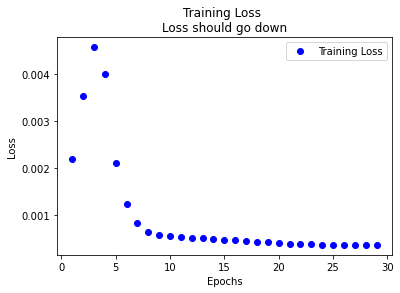

In [168]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.models.Sequential()
model.add(layers.LSTM(128,input_shape=(lb,1)))
model.add(layers.Dense(1))
model.compile(optimizer='adam',loss='mse')
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))
#Fit model with history to check for overfitting

model.summary() 

history = {
    "history" : {}
}

#running_loss
hp = {
    'rolling' : 10,
    'rolling_means' : [],
    'rolling_dif' : [],
}
for epoch in range(1,30): 
    #loop_history = model.fit(X_train,y_train,epochs=1,validation_data=(X_test,y_test),shuffle=False)
    loop_history = model.fit(X_train,y_train,epochs=1,shuffle=False)
    
                
    
    #//*** Add history values to running dictionary
    for key,value in loop_history.history.items():
        if key not in history["history"].keys():
            history["history"][key] = []
            history["history"][key].append(value[0])
            continue
        #print(history)
        history["history"][key].append(value[0])
        current_val = history['history'][key][-1]
        last_val = history['history'][key][-2]
        
        cur_rol_mean = np.array(history["history"][key][-5:]).mean()
        hp['rolling_means'].append(cur_rol_mean)
        
        if len(hp['rolling_means']) > hp['rolling']:
            del hp['rolling_means'][0]
        trp = np.array(hp['rolling_means'])
        rd = (trp.max()-trp.min())/trp.max() 
        rd = trp.mean()
        hp['rolling_dif'].append(rd)
        if len(hp['rolling_dif']) > hp['rolling']:
            del hp['rolling_dif'][0]
            rd = np.array(hp['rolling_dif']).mean()
            #trd = (trp.max()-trp.min())/trp.max()
            #rd = trp.mean()
            print(trp.mean(),rd)
        #prev_rol_mean = np.array(history["history"][key][-6:-1]).mean()
        #print( len(np.array(history["history"][key][-6:-1])), cur_rol_mean / current_val )

loss = history['history']['loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, "bo", label="Training Loss")

plt.title("Training Loss \nLoss should go down")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()    

In [190]:
y_test

array([0.15255886, 0.14877066, 0.14956893, 0.14522918, 0.14421318,
       0.14132486, 0.14255856, 0.13913321, 0.13485152, 0.13673837,
       0.13659324, 0.13859619, 0.13775437, 0.13599814, 0.13878487,
       0.13672386, 0.13373393, 0.13386455, 0.13003281, 0.12711544,
       0.1209469 , 0.12168713, 0.12396586, 0.1260414 , 0.12231125,
       0.12540276, 0.12193388, 0.12125172, 0.1214404 , 0.12072921,
       0.12816046, 0.12528667, 0.12608494, 0.1165491 , 0.11752155,
       0.12223867, 0.12091789, 0.11808762, 0.12080176, 0.12116462,
       0.11741996, 0.11885686, 0.11882783, 0.1177828 , 0.1169555 ,
       0.11737642, 0.12122267, 0.12337078, 0.12067114, 0.12035182,
       0.12157102, 0.11839241, 0.1204389 , 0.12139685, 0.12161458,
       0.12129526, 0.12686871, 0.12718803, 0.12827659, 0.13046823,
       0.12881361, 0.12759441, 0.12772505, 0.12779762, 0.12937967,
       0.12975703, 0.13274696, 0.13476443, 0.1345177 , 0.13469186,
       0.13467735, 0.135853  , 0.13499667, 0.134329  , 0.13363

Root Mean Square Error: 0.015801027731334526


Text(0.5, 1.0, 'Train Dataset')

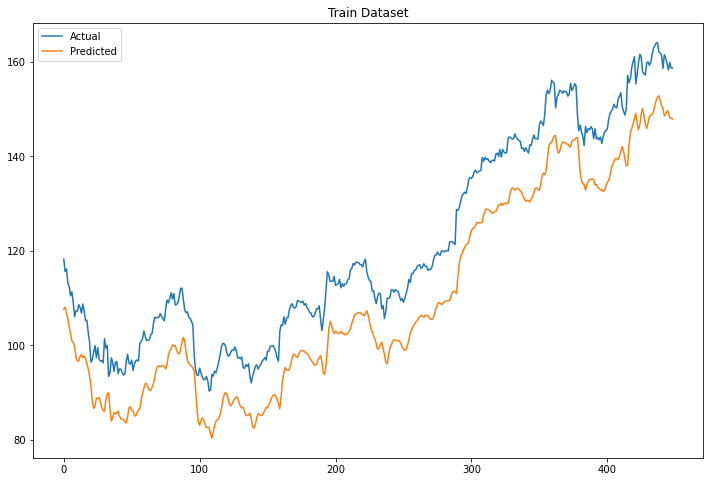

In [169]:
from sklearn.metrics import mean_squared_error
import math

Xt = model.predict(X_test)

MSE = mean_squared_error(y_test, Xt)
RMSE = math.sqrt(MSE)
print("Root Mean Square Error:",RMSE)

plt.figure(figsize=(12,8))

plt.plot(scl.inverse_transform(y_test.reshape(-1,1)), label="Actual")
plt.plot(scl.inverse_transform(Xt), label="Predicted")
plt.legend()
plt.title("Train Dataset")

Sorted Values, ascending
lb - 10

128 layers 30 epochs - Root Mean Square Error: 0.015801027731334526


lb - 5
128 layers 10 epochs - Root Mean Square Error: 0.010312849741255741
128 layers 30 epochs = Root Mean Square Error: 0.00571650968395317
128 layers 50 epochs = Root Mean Square Error: 0.0038468090557836816
128 layers 100 epochs = Root Mean Square Error: 0.00375437499561212
256 layers 10 epochs - 
256 layers 30 epochs = 
512 layers 10 epochs - 
512 layers 30 epochs = 
1024 layers 10 epochs - Root Mean Square Error: 0.004295116624926005
1024 layers 30 epochs = Root Mean Square Error: 0.003913252159334501
2048 layers 5 epochs - Root Mean Square Error: 0.0593618983947133
2048 layers 10 epochs = Root Mean Square Error: 0.026043733624048535
2048 layers 30 epochs = 

lb - 10
128 layers 10 epochs - Root Mean Square Error: 0.011764281452167806
128 layers 30 epochs = Root Mean Square Error: 0.004559742802870765
128 layers 50 epochs = Root Mean Square Error: 0.0037283054280801415
128 layers 100 epochs = Root Mean Square Error: 0.003799333628391276

256 layers 10 epochs - Root Mean Square Error: 0.010065434933725168
256 layers 30 epochs = Root Mean Square Error: 0.004352487668629892
512 layers 10 epochs - Root Mean Square Error: 0.004611682054666424
512 layers 30 epochs = Root Mean Square Error: 0.004295116624926005
1024 layers 10 epochs - Root Mean Square Error: 0.004295116624926005
1024 layers 30 epochs = Root Mean Square Error: 0.003913252159334501
2048 layers 5 epochs - Root Mean Square Error: 0.0593618983947133
2048 layers 10 epochs = Root Mean Square Error: 0.026043733624048535
2048 layers 30 epochs = 

lb - 5
128 layers 10 epochs - Root Mean Square Error: 0.010312849741255741
128 layers 30 epochs = Root Mean Square Error: 0.00571650968395317
128 layers 50 epochs = Root Mean Square Error: 0.0038468090557836816
128 layers 100 epochs = Root Mean Square Error: 0.00375437499561212
lb - 10
128 layers 10 epochs - Root Mean Square Error: 0.011764281452167806
128 layers 30 epochs = Root Mean Square Error: 0.004559742802870765
128 layers 50 epochs = Root Mean Square Error: 0.0037283054280801415
128 layers 100 epochs = Root Mean Square Error: 0.003799333628391276
lb - 20
128 layers 10 epochs - Root Mean Square Error: 0.011828249964138964
128 layers 30 epochs = Root Mean Square Error: 0.005597271123280148
128 layers 50 epochs = Root Mean Square Error: 0.00422136500491414
128 layers 100 epochs = Root Mean Square Error: 0.003936937147377181

lb - 30
128 layers 10 epochs - Root Mean Square Error: 0.011189743244230738
128 layers 30 epochs = Root Mean Square Error: 0.004717327617405892
128 layers 50 epochs = Root Mean Square Error: 0.0038239943935830752
128 layers 100 epochs = Root Mean Square Error: 0.0037748931611001468

256 layers 10 epochs - Root Mean Square Error: 0.009339082448300055
256 layers 30 epochs = Root Mean Square Error: 0.005605373133054029

In [61]:
#Create a function to process the data into lb observations look back slices
# and create the train test dataset (90-10)
def processData(data,lb):
    X,Y = [],[]
    for i in range(len(data)-lb-1):
        X.append(data[i:(i+lb),0])
        Y.append(data[(i+lb),0])
    return np.array(X),np.array(Y)

#//*** lb = Look Back: the number of previous values to consider when applying the current value
lb=10


out_df = out_df.sort_values(by='date',ascending=True)
print(out_df)
cl = out_df['close'].astype('float32')
#cl = out_df['date']
#//*** Second to last value, used to predict y_test
x_test  = cl.iloc[-2]
#//*** Last Value in Data Set - Used to evaluate the prediction
y_test = cl.iloc[-1]

x_train = cl.iloc[-51:-1]

print("== CL ==")
print("x_test",x_test)
print("y_test",y_test)
#print(cl)



#//*** Scale the Data between 0 and 1
scl = MinMaxScaler()

#//*** Scale and reshape the data. Each value is returned as a list within a list
cl = scl.fit_transform(cl.values.reshape(-1,1))
#cl = cl.values.reshape(-1,1)

#//*** Build Data for Lookback arrays
X_train,y_train = processData(cl,lb)

print("== X ==")
print(X_train)
print("== y ==")
print(y_train)

print(X_train.shape,y_train.shape)

#//*** Build the test value using the last element of X_train
x_test = X_train[-1]

x_test.shape
print(x_test.shape)
#//*** Remove the first element
x_test = np.delete(x_test,0)
#//*** Add the last element of y_train, as our predict ahead
x_test = np.append(x_test,y_train[-1])



print(x_test.shape)

print(x_test.shape)
print(x_test)

            date symbol     open    high     low   close     volume
5626  1999-11-01   AAPL   80.000   80.69   77.37   77.62    2487300
5625  1999-11-02   AAPL   78.000   81.69   77.31   80.25    3564600
5624  1999-11-03   AAPL   81.620   83.25   81.00   81.50    2932700
5623  1999-11-04   AAPL   82.060   85.37   80.62   83.62    3384700
5622  1999-11-05   AAPL   84.620   88.37   84.00   88.31    3721500
...          ...    ...      ...     ...     ...     ...        ...
4     2022-03-07   AAPL  163.360  165.02  159.04  159.30   96418845
3     2022-03-08   AAPL  158.820  162.88  155.80  157.44  131148280
2     2022-03-09   AAPL  161.475  163.41  159.41  162.95   91454905
1     2022-03-10   AAPL  160.200  160.39  155.98  158.52  105342033
0     2022-03-11   AAPL  158.930  159.28  154.50  154.73   96970102

[5627 rows x 7 columns]
== CL ==
x_test 158.52
y_test 154.73
== X ==
[[0.09361666 0.09743389 0.09924816 ... 0.1136753  0.11485094 0.11248513]
 [0.09743389 0.09924816 0.10232519 ... 0.

In [12]:
X_train[-1].reshape(-1,1).shape

(10, 1)

In [311]:
print(y_test)
y_train

154.73


array([0.7624631 , 0.64002943, 0.67228746, 0.55241966, 0.4215541 ,
       0.3585043 , 0.28152514, 0.25256586, 0.18511724, 0.18181801,
       0.1645894 , 0.57184744, 0.73497057, 0.7287388 , 0.7738266 ,
       0.6660557 , 0.6473608 , 0.6206012 , 0.73680353, 0.7899561 ,
       0.6374631 , 0.50989723, 0.51869535, 0.66202307, 0.6532259 ,
       0.51869535, 0.46077728, 0.3515396 , 0.19574785, 0.29362202,
       0.37096786, 0.3808651 , 0.31048393, 0.43365097, 0.4215541 ,
       0.30938387, 0.16752195, 0.09933996, 0.3013196 , 0.13892984],
      dtype=float32)

In [17]:
out_df.iloc[-52:]

,date,symbol,open,high,low,close,volume
51,2021-12-28,AAPL,180.160,181.3300,178.5300,179.29,79144339
50,2021-12-29,AAPL,179.330,180.6300,178.1400,179.38,62348931
49,2021-12-30,AAPL,179.470,180.5700,178.0900,178.20,59773014
48,2021-12-31,AAPL,178.085,179.2300,177.2600,177.57,61661433
47,2022-01-03,AAPL,177.830,182.8800,177.7100,182.01,104701220
46,2022-01-04,AAPL,182.630,182.9400,179.1200,179.70,99310438
45,2022-01-05,AAPL,179.610,180.1700,174.6400,174.92,94537602
44,2022-01-06,AAPL,172.700,175.3000,171.6400,172.00,96903955
43,2022-01-07,AAPL,172.890,174.1400,171.0300,172.17,86709147
42,2022-01-10,AAPL,169.080,172.5000,168.1700,172.19,106765552


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________
176/176 [==============================] - 1s 4ms/step - loss: 4.2143e-04
0.0013325456337770446 0.0020075201852051247
176/176 [==============================] - 1s 4ms/step - loss: 4.0199e-04
0.0011127770628081635 0.0018657299400693442
176/176 [==============================] - 1s 4ms/step - loss: 3.8531e-04
0.0009143026184756308 0.0017082172663880526
176/176 [==============================] - 1s 4ms/step - loss: 3.7272e-04
0.0007428129587788134 0.001542803762154469
176/176 [==============================] 

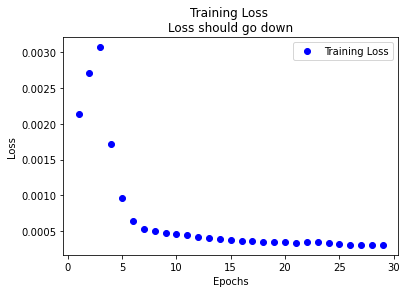

In [62]:
model = keras.models.Sequential()
model.add(layers.LSTM(128,input_shape=(lb,1)))
model.add(layers.Dense(1))
model.compile(optimizer='adam',loss='mse')
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
#X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))
#Fit model with history to check for overfitting

#//*** Reshape x_test to match the X_train shape
x_test = X_train[-1].reshape((X_train[-1].shape[1],X_train[-1].shape[0],1))

model.summary() 

history = {
    "history" : {}
}

#running_loss
hp = {
    'rolling' : 10,
    'rolling_means' : [],
    'rolling_dif' : [],
}
for epoch in range(1,30): 
    #loop_history = model.fit(X_train,y_train,epochs=1,validation_data=(X_test,y_test),shuffle=False)
    loop_history = model.fit(X_train,y_train,epochs=1,shuffle=False)
    
                
    
    #//*** Add history values to running dictionary
    for key,value in loop_history.history.items():
        if key not in history["history"].keys():
            history["history"][key] = []
            history["history"][key].append(value[0])
            continue
        #print(history)
        history["history"][key].append(value[0])
        current_val = history['history'][key][-1]
        last_val = history['history'][key][-2]
        
        cur_rol_mean = np.array(history["history"][key][-5:]).mean()
        hp['rolling_means'].append(cur_rol_mean)
        
        if len(hp['rolling_means']) > hp['rolling']:
            del hp['rolling_means'][0]
        trp = np.array(hp['rolling_means'])
        rd = (trp.max()-trp.min())/trp.max() 
        rd = trp.mean()
        hp['rolling_dif'].append(rd)
        if len(hp['rolling_dif']) > hp['rolling']:
            del hp['rolling_dif'][0]
            rd = np.array(hp['rolling_dif']).mean()
            #trd = (trp.max()-trp.min())/trp.max()
            #rd = trp.mean()
            print(trp.mean(),rd)
        #prev_rol_mean = np.array(history["history"][key][-6:-1]).mean()
        #print( len(np.array(history["history"][key][-6:-1])), cur_rol_mean / current_val )

loss = history['history']['loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, "bo", label="Training Loss")

plt.title("Training Loss \nLoss should go down")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()    


In [64]:
cl
#Xt = model.predict(X_test)
Xt = model.predict(X_train)
Xt
print(X_train.shape)


Xt = model.predict(x_test)

print(scl.inverse_transform(Xt))
print(y_test)
#plt.plot(scl.inverse_transform(y_test.reshape(-1,1)), label="Actual")
#plt.plot(scl.inverse_transform(Xt), label="Predicted")


(5616, 10, 1)
[[160.96553]]
154.73


In [137]:
"""
#Create a function to process the data into lb observations look back slices
# and create the train test dataset (90-10)
def processData(data,lb):
    X,Y = [],[]
    for i in range(len(data)-lb-1):
        X.append(data[i:(i+lb),0])
        Y.append(data[(i+lb),0])
    return np.array(X),np.array(Y)

#//*** lb = Look Back: the number of previous values to consider when applying the current value
lb=10

#//**** Model Parameters
mp = {
    'size' : 30, #//*** Total number of days to model
    'lb' : 3, #//*** Look Back, how many days prior to consider as part of the LSTM model
    
}

#//*** Load the DataFrame. Must be sorted by ascending value
#print(out_df[-32:])
print(len(out_df),len(out_df)-mp['size'])
for loop_index in range(len(out_df)-mp['size'],-1,-1):
    max_index = loop_index + mp['size']
    print(loop_index,max_index)
    print(out_df.iloc[loop_index:max_index])
    cl = out_df.iloc[loop_index:max_index]['close'].astype('float32')
    
    y_test = out_df.iloc[loop_index]['close'].astype('float32')
    print(cl)
    print("Last")
    print(out_df.iloc[loop_index])
    print("===Predict===")
    print(out_df.iloc[loop_index-1])
    print("======")
    
    #//*** Scale the Data between 0 and 1
    scl = MinMaxScaler()

    #//*** Scale and reshape the data. Each value is returned as a list within a list
    #cl = scl.fit_transform(cl.values.reshape(-1,1))
    cl = cl.values.reshape(-1,1)
    print(cl)
    
    #//*** Build Data for Lookback arrays
    X_train,y_train = processData(cl,mp['lb'])

    print("== X ==")
    print(X_train)
    print("== y ==")
    print(y_train)

    print(X_train.shape,y_train.shape)

    #//*** Build the test value using the last element of X_train
    x_test = X_train[-1]

    x_test.shape
    print(x_test.shape)
    #//*** Remove the first element
    x_test = np.delete(x_test,0)
    #//*** Add the last element of y_train, as our predict ahead
    x_test = np.append(x_test,y_train[-1])



    
    print("xt,yt",x_train.shape,y_train.shape)

    print(x_test.shape)
    print(x_test)    
    break
"""
print()

In [2]:
try:
    symbol
except:
    symbol = symbols[0]
    action = "daily"
input_filename = f"./stocks/{symbol}_{action}.csv.zip"

#//*** Convert Path to Mac formatting if needed
#if platform.system() == 'Darwin':
    #output_filename = output_filename.replace("\\","/")


print(f"Reading dataframe from File: {input_filename}")
out_df = pd.read_csv(input_filename)

out_df = out_df.sort_values(by='date',ascending=True)
out_df = out_df.reset_index(drop=True)
out_df['date'] = pd.to_datetime(out_df['date'])

months_to_model = 6
out_df = out_df[ out_df['date'] >= out_df['date'].max()-pd.DateOffset(months=months_to_model) ]
out_df


Reading dataframe from File: ./stocks/AAPL_daily.csv.zip


,date,symbol,open,high,low,close,volume
5501,2021-09-13,AAPL,150.630,151.42,148.750,149.55,102404329
5502,2021-09-14,AAPL,150.350,151.07,146.910,148.12,109296295
5503,2021-09-15,AAPL,148.560,149.44,146.370,149.03,83281315
5504,2021-09-16,AAPL,148.440,148.97,147.221,148.79,68034149
5505,2021-09-17,AAPL,148.820,148.82,145.760,146.06,129868824
...,...,...,...,...,...,...,...
5622,2022-03-07,AAPL,163.360,165.02,159.040,159.30,96418845
5623,2022-03-08,AAPL,158.820,162.88,155.800,157.44,131148280
5624,2022-03-09,AAPL,161.475,163.41,159.410,162.95,91454905
5625,2022-03-10,AAPL,160.200,160.39,155.980,158.52,105342033


In [7]:
#Create a function to process the data into lb observations look back slices
# and create the train test dataset (90-10)
def processData(data,lb):
    X,Y = [],[]
    for i in range(len(data)-lb-1):
        X.append(data[i:(i+lb),0])
        Y.append(data[(i+lb),0])
    return np.array(X),np.array(Y)

def build_model(num_layers,lb,activation):
    model = keras.models.Sequential()
    #model.add(layers.LSTM(num_layers,activation=activation, input_shape=(lb,1)))
    
    #//*** Hidden Layers Don't seem to be the answer
    model.add(layers.LSTM(num_layers,activation=activation,return_sequences=True, input_shape=(lb,1)))
    #model.add(layers.LSTM(num_layers,activation=activation,return_sequences=True) )
    model.add(layers.LSTM(num_layers,activation=activation) )
    model.add(layers.Dense(1))
    model.compile(optimizer='adam',loss='mse')
    
    return model
    
#//**** Model Parameters
mp = {
    'size' : 120, #//*** Total number of days to model
    'lb' : 10, #//*** Look Back, how many days prior to consider as part of the LSTM model
    'layers' : 256,
    'epochs' : 50,
    'months_to_model' : 7,
    'activation' : 'relu',
}
#running_loss
hp = {
    'rolling' : 10,
    'rolling_means' : [],
    'rolling_dif' : [],
}

try:
    symbol
except:
    symbol = symbols[0]
    action = "daily"
input_filename = f"./stocks/{symbol}_{action}.csv.zip"

#//*** Convert Path to Mac formatting if needed
#if platform.system() == 'Darwin':
    #output_filename = output_filename.replace("\\","/")


print(f"Reading dataframe from File: {input_filename}")
out_df = pd.read_csv(input_filename)

out_df = out_df.sort_values(by='date',ascending=True)
out_df = out_df.reset_index(drop=True)
out_df['date'] = pd.to_datetime(out_df['date'])

#month_offset = int(int(mp['size'] / 30)*2)
#print("month_offset:",month_offset)
out_df = out_df[ out_df['date'] >= out_df['date'].max()-pd.DateOffset(months=mp['months_to_model']) ]
#out_df = out_df[ out_df['date'] >= out_df['date'].max()-pd.DateOffset(months=month_offset) ]
#out_df = out_df[ out_df['date'] >= out_df['date'].max()-pd.DateOffset(days=day_offset) ]
print(out_df)



#cl = out_df['close'].astype('float32')

#//*** Start with first Item
#base_index = 0

#//*** Collect range of data between base_index and mp['size']
#max_index = base_index + mp['size']

#cl = out_df.iloc[base_index:max_index]['close'].astype('float32')
#cl = out_df.iloc[base_index:max_index]

#///**** Value to Predict is the max_index
#y_test = out_df.iloc[max_index]['close'].astype('float32')
#print(cl)
#print(cl)
#print("Last")
#print(out_df.iloc[max_index-1])
#print("Predict")
#print(out_df.iloc[max_index])
predictions = []
actuals = []

max_loop = len(out_df)-mp['size'] - 1
start_time = time.time()
print("1 /",max_loop)
print(range(0,len(out_df)-mp['size']))
for loop_index in range(0,len(out_df)-mp['size']):
    #print(loop_index,"/",max_loop)
    loop_time = time.time()
    #//*** Collect range of data between base_index and mp['size']
    max_index = loop_index + mp['size']
    
    cl = out_df.iloc[loop_index:max_index]['close'].astype('float32')
    y_test = out_df.iloc[max_index]['close'].astype('float32')
    #print(cl)
    #print("Last")
    #print(out_df.iloc[max_index-1])
    #print("Predict")
    #print(out_df.iloc[max_index])
    
    #//*** Scale the Data between 0 and 1
    scl = MinMaxScaler()

    #//*** Scale and reshape the data. Each value is returned as a list within a list
    cl = scl.fit_transform(cl.values.reshape(-1,1))
    #cl = cl.values.reshape(-1,1)
    #print(cl)
    
    #//*** Build Data for Lookback arrays
    X_train,y_train = processData(cl,mp['lb'])

    #print("== X ==")
    #print(X_train)
    #print("== y ==")
    #print(y_train)

    #print(X_train.shape,y_train.shape)
    
    #//*** Build the test value using the last element of X_train
    x_test = X_train[-1]

    #//*** Remove the first element
    x_test = np.delete(x_test,0)
    #//*** Add the last element of y_train, as our predict ahead
    x_test = np.append(x_test,y_train[-1])


    #print("x_test")
    #print(x_test.shape)
    #print(x_test)
    #print("to Predict y_test")
    #print(y_test)
    
    #//**** Good to this point
    

    
    
    X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
    #X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))
    #Fit model with history to check for overfitting

    #//*** Reshape x_test to match the X_train shape
    x_test = X_train[-1].reshape((X_train[-1].shape[1],X_train[-1].shape[0],1))

    #model.summary() 

    model = build_model(mp['layers'],mp['lb'],mp['activation'])

        
    model.fit(X_train,y_train,epochs=mp['epochs'],shuffle=False,verbose=0)
    
    Xt = model.predict(x_test)
    
    predict = scl.inverse_transform(Xt)[0][0]
    predictions.append(predict)
    actuals.append(y_test)
    
    remain_loop = max_loop - loop_index
    cycle_time = int(time.time() - loop_time)
    clear_output(wait=True)
    print(loop_index,"/",max_loop,"[",predict,"] - ",y_test, " ",cycle_time, "s - remaining: ",cycle_time*remain_loop,"s" )
    
    #break
    #    #break

total_time = int(time.time() - start_time)


print("=================")
print("DONE: ", total_time,"secs")
print("=================")
playsound.playsound(sound_filename)

27 / 27 [ 163.8397 ] -  154.73   6 s - remaining:  0 s
DONE:  196 secs


Run Time:  196 s
Total Models:  27
{'size': 120, 'lb': 10, 'layers': 256, 'epochs': 50, 'months_to_model': 7, 'activation': 'relu'}


Text(0.5, 1.0, 'First Passes Evals Dataset')

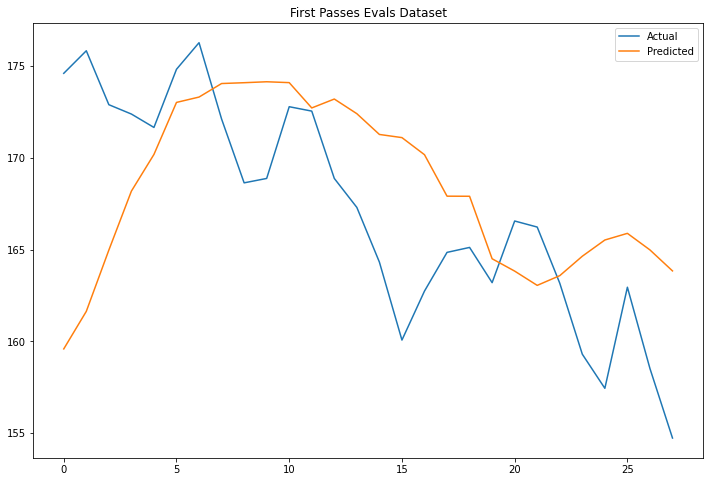

In [8]:
#//**** 1 Hidden Layers
#//***** 256 Layers 50 EPOCHS -- LB 10 == Size 60 - Model Months: 4 - activation: sigmoid
print("Run Time: ", total_time, "s")
print("Total Models: ", max_loop)
print(mp)
plt.figure(figsize=(12,8))

plt.plot(actuals, label="Actual")
plt.plot(predictions, label="Predicted")
plt.legend()
plt.title("First Passes Evals Dataset")

Run Time:  194 s
Total Models:  27
{'size': 120, 'lb': 10, 'layers': 256, 'epochs': 50, 'months_to_model': 7, 'activation': 'relu'}


Text(0.5, 1.0, 'First Passes Evals Dataset')

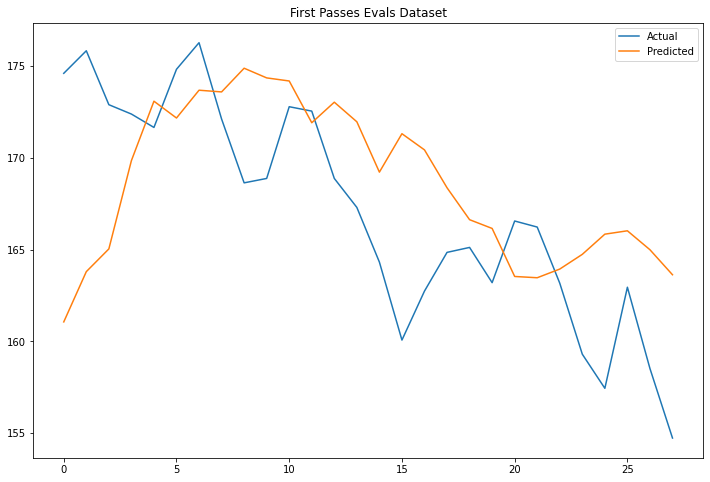

In [6]:
#//**** 1 Hidden Layers
#//***** 256 Layers 50 EPOCHS -- LB 10 == Size 60 - Model Months: 4 - activation: sigmoid
print("Run Time: ", total_time, "s")
print("Total Models: ", max_loop)
print(mp)
plt.figure(figsize=(12,8))

plt.plot(actuals, label="Actual")
plt.plot(predictions, label="Predicted")
plt.legend()
plt.title("First Passes Evals Dataset")

Run Time:  158 s
Total Models:  22
{'size': 60, 'lb': 10, 'layers': 256, 'epochs': 50, 'months_to_model': 4, 'activation': 'sigmoid'}


Text(0.5, 1.0, 'First Passes Evals Dataset')

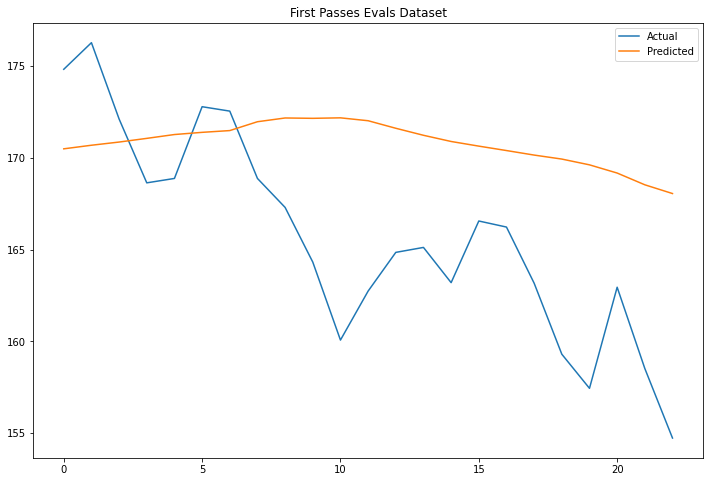

In [109]:
#//**** 2 Hidden Layers
#//***** 256 Layers 50 EPOCHS -- LB 10 == Size 60 - Model Months: 4 - activation: sigmoid
print("Run Time: ", total_time, "s")
print("Total Models: ", max_loop)
print(mp)
plt.figure(figsize=(12,8))

plt.plot(actuals, label="Actual")
plt.plot(predictions, label="Predicted")
plt.legend()
plt.title("First Passes Evals Dataset")

Run Time:  163 s
Total Models:  22
{'size': 60, 'lb': 10, 'layers': 256, 'epochs': 50, 'months_to_model': 4, 'activation': 'relu'}


Text(0.5, 1.0, 'First Passes Evals Dataset')

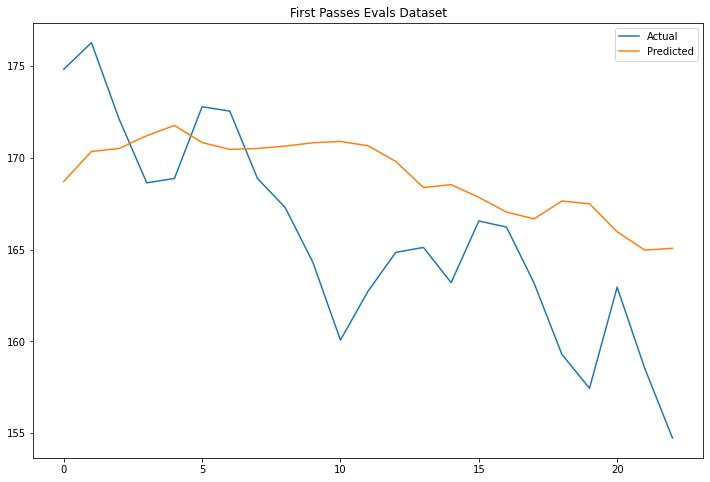

In [107]:
#//**** 2 Hidden Layers
#//***** 256 Layers 50 EPOCHS -- LB 10 == Size 60 - Model Months: 4 - activation: relu
print("Run Time: ", total_time, "s")
print("Total Models: ", max_loop)
print(mp)
plt.figure(figsize=(12,8))

plt.plot(actuals, label="Actual")
plt.plot(predictions, label="Predicted")
plt.legend()
plt.title("First Passes Evals Dataset")

Run Time:  102 s
Total Models:  22
{'size': 60, 'lb': 10, 'layers': 256, 'epochs': 50, 'months_to_model': 4, 'activation': 'relu'}


Text(0.5, 1.0, 'First Passes Evals Dataset')

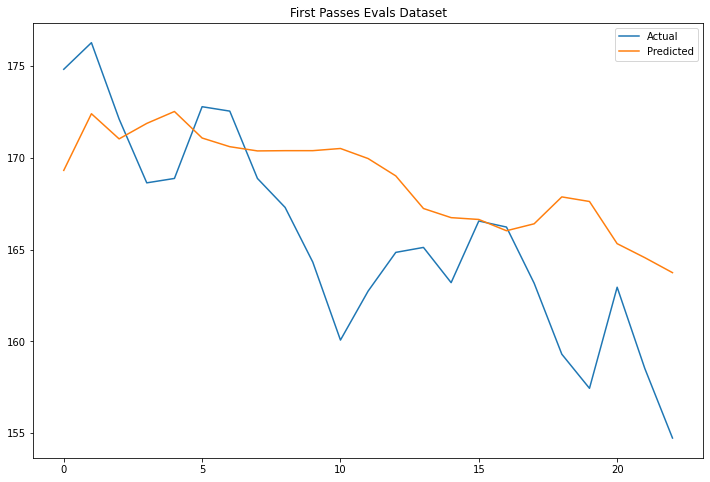

In [103]:
#//**** 1 Hidden Layer
#//***** 256 Layers 50 EPOCHS -- LB 10 == Size 60 - Model Months: 4 - activation: relu
print("Run Time: ", total_time, "s")
print("Total Models: ", max_loop)
print(mp)
plt.figure(figsize=(12,8))

plt.plot(actuals, label="Actual")
plt.plot(predictions, label="Predicted")
plt.legend()
plt.title("First Passes Evals Dataset")

Run Time:  50 s
Total Models:  22
{'size': 60, 'lb': 10, 'layers': 256, 'epochs': 50, 'months_to_model': 4, 'activation': 'relu'}


Text(0.5, 1.0, 'First Passes Evals Dataset')

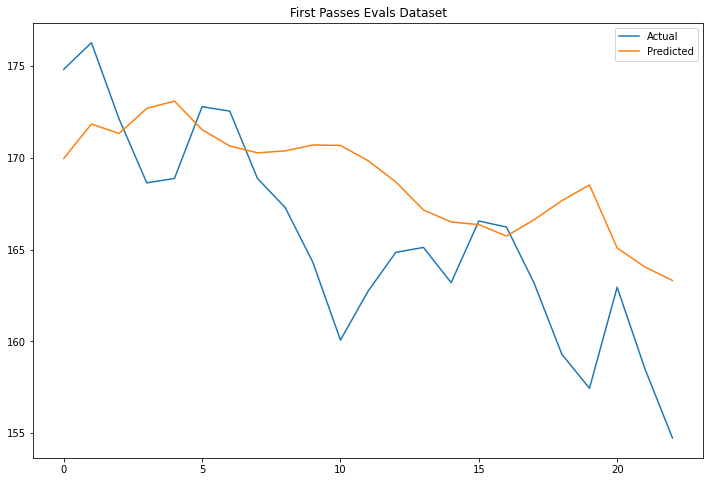

In [98]:
#//***** 256 Layers 50 EPOCHS -- LB 10 == Size 60 - Model Months: 4 - activation: relu
print("Run Time: ", total_time, "s")
print("Total Models: ", max_loop)
print(mp)
plt.figure(figsize=(12,8))

plt.plot(actuals, label="Actual")
plt.plot(predictions, label="Predicted")
plt.legend()
plt.title("First Passes Evals Dataset")

Run Time:  51 s
Total Models:  22
{'size': 60, 'lb': 10, 'layers': 256, 'epochs': 50, 'months_to_model': 4, 'activation': 'sigmoid'}


Text(0.5, 1.0, 'First Passes Evals Dataset')

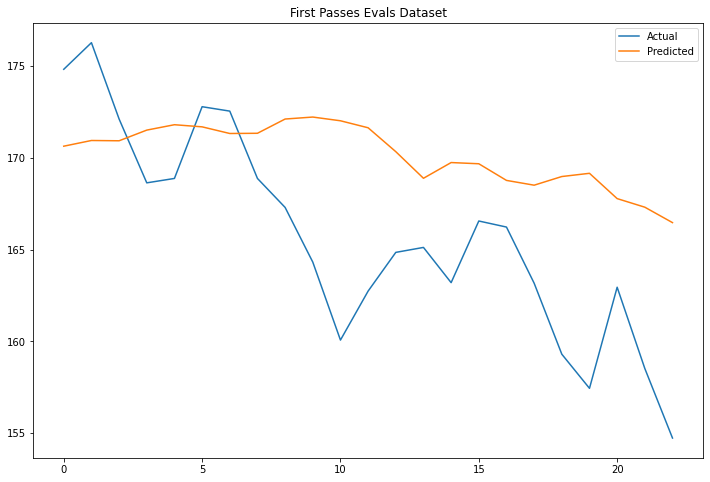

In [100]:
#//***** 256 Layers 50 EPOCHS -- LB 20 == Size 60 - Model Months: 4 - activation: sigmoid
print("Run Time: ", total_time, "s")
print("Total Models: ", max_loop)
print(mp)
plt.figure(figsize=(12,8))

plt.plot(actuals, label="Actual")
plt.plot(predictions, label="Predicted")
plt.legend()
plt.title("First Passes Evals Dataset")

Run Time:  151 s
Total Models:  39
{'size': 360, 'lb': 10, 'layers': 256, 'epochs': 20, 'months_to_model': 19}


Text(0.5, 1.0, 'First Passes Evals Dataset')

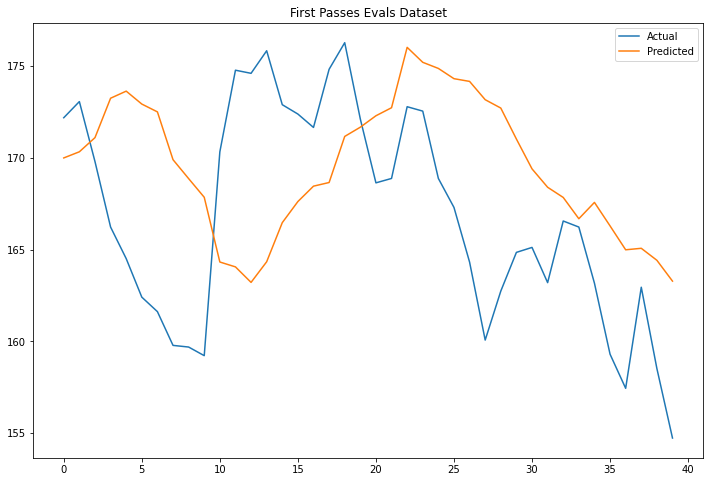

In [84]:
#//***** 256 Layers 20 EPOCHS -- LB 10 == Size 360 - Model Months: 19 - activation: relu
print("Run Time: ", total_time, "s")
print("Total Models: ", max_loop)
print(mp)
plt.figure(figsize=(12,8))

plt.plot(actuals, label="Actual")
plt.plot(predictions, label="Predicted")
plt.legend()
plt.title("First Passes Evals Dataset")

Run Time:  190 s
Total Models:  39
{'size': 360, 'lb': 10, 'layers': 256, 'epochs': 20, 'months_to_model': 19}


Text(0.5, 1.0, 'First Passes Evals Dataset')

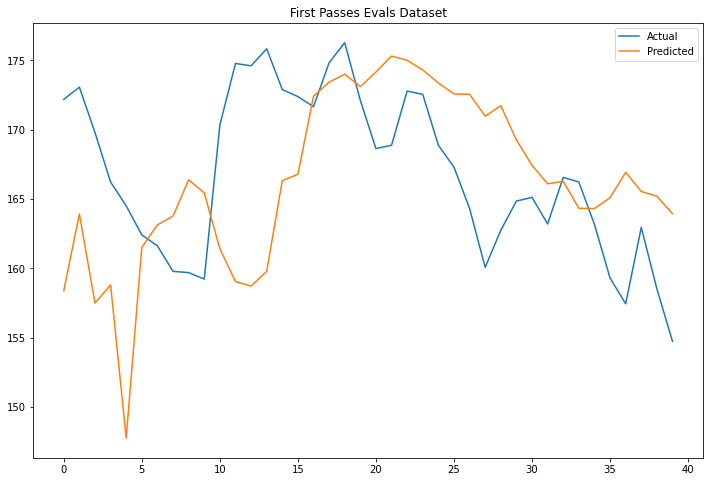

In [82]:
#//***** 256 Layers 20 EPOCHS -- LB 10 == Size 360 - Model Months: 19
print("Run Time: ", total_time, "s")
print("Total Models: ", max_loop)
print(mp)
plt.figure(figsize=(12,8))

plt.plot(actuals, label="Actual")
plt.plot(predictions, label="Predicted")
plt.legend()
plt.title("First Passes Evals Dataset")

Run Time:  115 s
Total Models:  39
{'size': 360, 'lb': 2, 'layers': 256, 'epochs': 20, 'months_to_model': 19}


Text(0.5, 1.0, 'First Passes Evals Dataset')

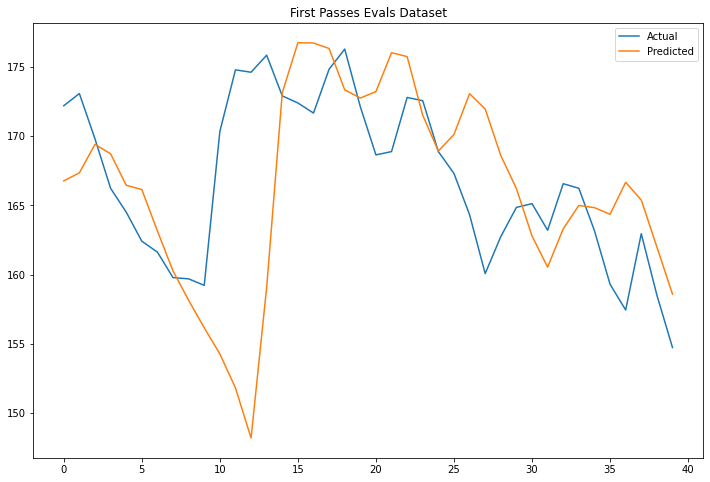

In [80]:
#//***** 256 Layers 20 EPOCHS -- LB 2 == Size 360 - Model Months: 19
print("Run Time: ", total_time, "s")
print("Total Models: ", max_loop)
print(mp)
plt.figure(figsize=(12,8))

plt.plot(actuals, label="Actual")
plt.plot(predictions, label="Predicted")
plt.legend()
plt.title("First Passes Evals Dataset")

Run Time:  163 s
Total Models:  39
{'size': 360, 'lb': 2, 'layers': 256, 'epochs': 50, 'months_to_model': 19}


Text(0.5, 1.0, 'First Passes Evals Dataset')

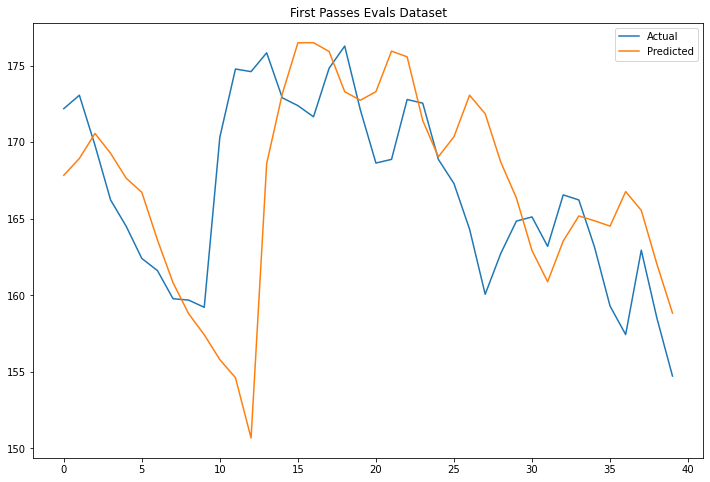

In [78]:
#//***** 256 Layers 50 EPOCHS -- LB 2 == Size 360 - Model Months: 19
print("Run Time: ", total_time, "s")
print("Total Models: ", max_loop)
print(mp)
plt.figure(figsize=(12,8))

plt.plot(actuals, label="Actual")
plt.plot(predictions, label="Predicted")
plt.legend()
plt.title("First Passes Evals Dataset")

Run Time:  242 s
Total Models:  39
{'size': 360, 'lb': 2, 'layers': 256, 'epochs': 100, 'months_to_model': 19}


Text(0.5, 1.0, 'First Passes Evals Dataset')

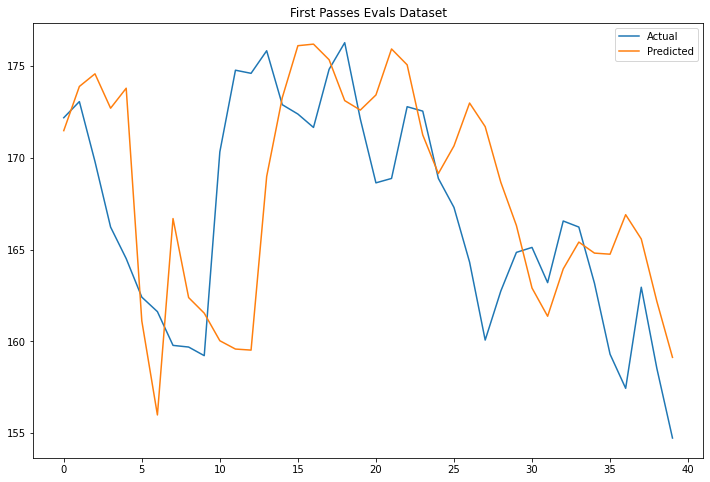

In [76]:
#//***** 256 Layers 100 EPOCHS -- LB 2 == Size 360 - Model Months: 19
print("Run Time: ", total_time, "s")
print("Total Models: ", max_loop)
print(mp)
plt.figure(figsize=(12,8))

plt.plot(actuals, label="Actual")
plt.plot(predictions, label="Predicted")
plt.legend()
plt.title("First Passes Evals Dataset")

Run Time:  130 s
Total Models:  31
{'size': 180, 'lb': 2, 'layers': 256, 'epochs': 100, 'months_to_model': 10}


Text(0.5, 1.0, 'First Passes Evals Dataset')

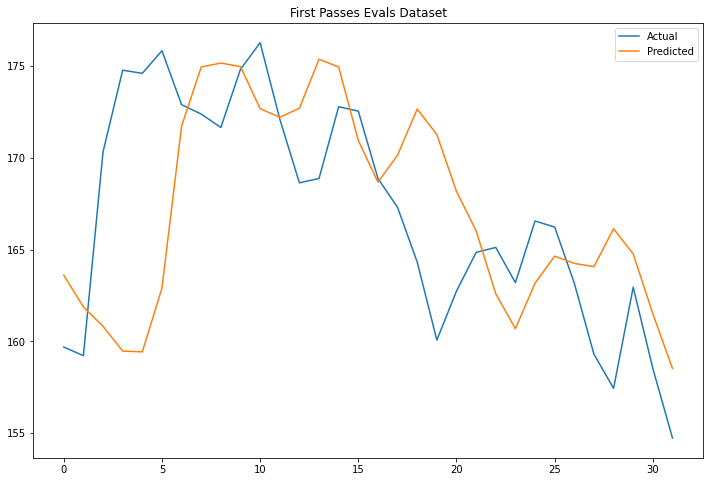

In [72]:
#//***** 256 Layers 100 EPOCHS -- LB 2 == Size 180 - Model Months: 7
print("Run Time: ", total_time, "s")
print("Total Models: ", max_loop)
print(mp)
plt.figure(figsize=(12,8))

plt.plot(actuals, label="Actual")
plt.plot(predictions, label="Predicted")
plt.legend()
plt.title("First Passes Evals Dataset")

Run Time:  164 s
Total Models:  38
{'size': 180, 'lb': 2, 'layers': 256, 'epochs': 100, 'months_to_model': 7}


Text(0.5, 1.0, 'First Passes Evals Dataset')

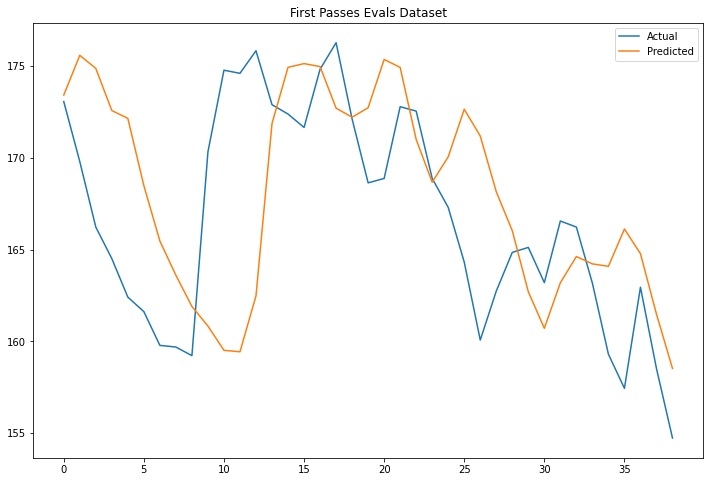

In [47]:
#//***** 256 Layers 100 EPOCHS -- LB 2 == Size 180 - Model Months: 7
print("Run Time: ", total_time, "s")
print("Total Models: ", max_loop)
print(mp)
plt.figure(figsize=(12,8))

plt.plot(actuals, label="Actual")
plt.plot(predictions, label="Predicted")
plt.legend()
plt.title("First Passes Evals Dataset")

Run Time:  95 s
Total Models:  27
{'size': 120, 'lb': 2, 'layers': 256, 'epochs': 100, 'months_to_model': 7}


Text(0.5, 1.0, 'First Passes Evals Dataset')

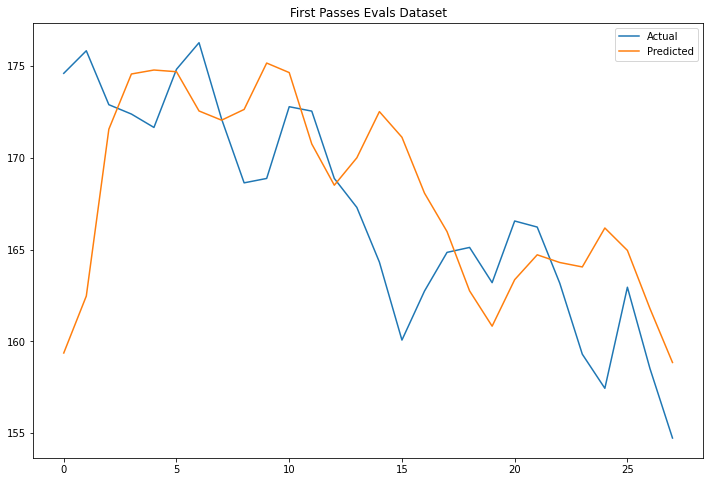

In [41]:
#//***** 256 Layers 100 EPOCHS -- LB 2 == Size 120 - Model Months: 7
print("Run Time: ", total_time, "s")
print("Total Models: ", max_loop)
print(mp)
plt.figure(figsize=(12,8))

plt.plot(actuals, label="Actual")
plt.plot(predictions, label="Predicted")
plt.legend()
plt.title("First Passes Evals Dataset")

Run Time:  64 s
Total Models:  22
{'size': 60, 'lb': 2, 'layers': 256, 'epochs': 100, 'months_to_model': 4}


Text(0.5, 1.0, 'First Passes Evals Dataset')

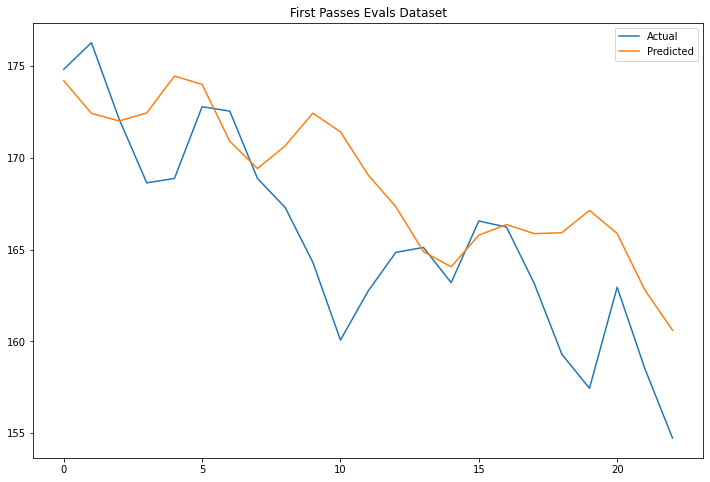

In [35]:
#//***** 256 Layers 100 EPOCHS -- LB 3 == Size 60 - Model Months: 4
print("Run Time: ", total_time, "s")
print("Total Models: ", max_loop)
print(mp)
plt.figure(figsize=(12,8))

plt.plot(actuals, label="Actual")
plt.plot(predictions, label="Predicted")
plt.legend()
plt.title("First Passes Evals Dataset")

Run Time:  117 s
Total Models:  22
{'size': 60, 'lb': 30, 'layers': 256, 'epochs': 100, 'months_to_model': 4}


Text(0.5, 1.0, 'First Passes Evals Dataset')

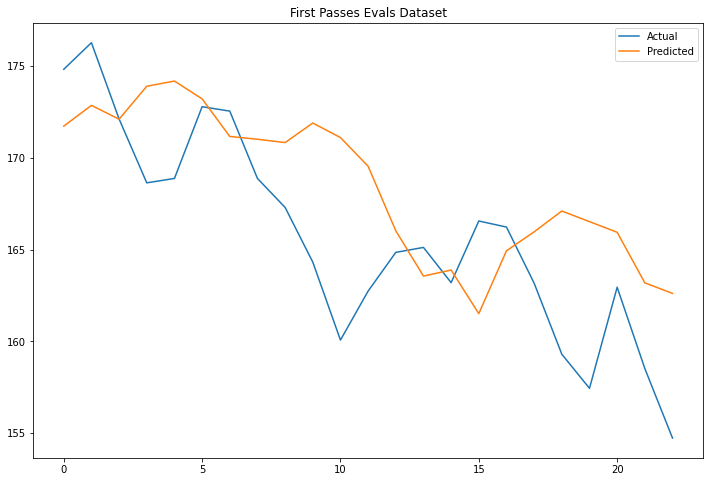

In [33]:
#//***** 256 Layers 100 EPOCHS -- LB 30 == Size 60 - Model Months: 4
print("Run Time: ", total_time, "s")
print("Total Models: ", max_loop)
print(mp)
plt.figure(figsize=(12,8))

plt.plot(actuals, label="Actual")
plt.plot(predictions, label="Predicted")
plt.legend()
plt.title("First Passes Evals Dataset")

Run Time:  73 s
Total Models:  31
{'size': 30, 'lb': 10, 'layers': 256, 'epochs': 20, 'months_to_model': 3}


Text(0.5, 1.0, 'First Passes Evals Dataset')

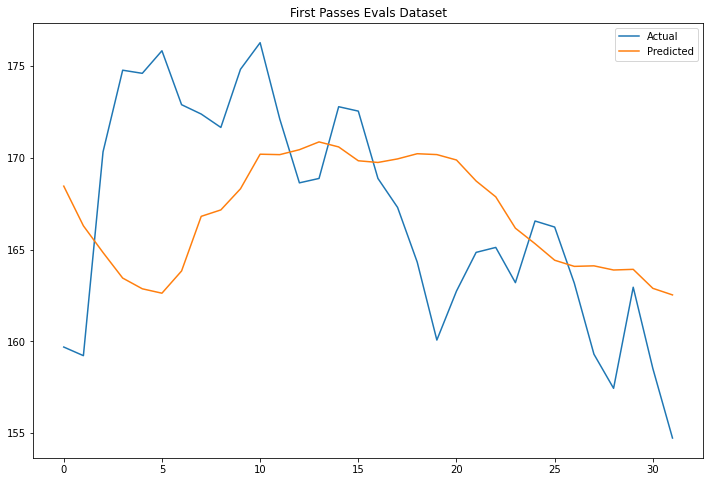

In [32]:
#//***** 256 Layers 20 EPOCHS -- LB 10
print("Run Time: ", total_time, "s")
print("Total Models: ", max_loop)
print(mp)
plt.figure(figsize=(12,8))

plt.plot(actuals, label="Actual")
plt.plot(predictions, label="Predicted")
plt.legend()
plt.title("First Passes Evals Dataset")

Run Time:  207 s
Total Models:  95
{'size': 30, 'lb': 10, 'layers': 64, 'epochs': 20, 'months_to_model': 6}


Text(0.5, 1.0, 'First Passes Evals Dataset')

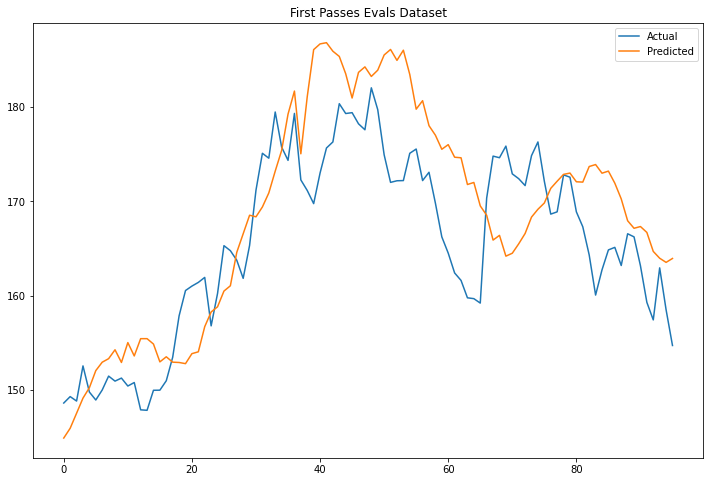

In [5]:
#//***** 64 Layers 20 EPOCHS -- LB 10
print("Run Time: ", total_time, "s")
print("Total Models: ", max_loop)
print(mp)
plt.figure(figsize=(12,8))

plt.plot(actuals, label="Actual")
plt.plot(predictions, label="Predicted")
plt.legend()
plt.title("First Passes Evals Dataset")

Run Time:  204 s
Total Models:  95
{'size': 30, 'lb': 10, 'layers': 128, 'epochs': 20, 'months_to_model': 6}


Text(0.5, 1.0, 'First Passes Evals Dataset')

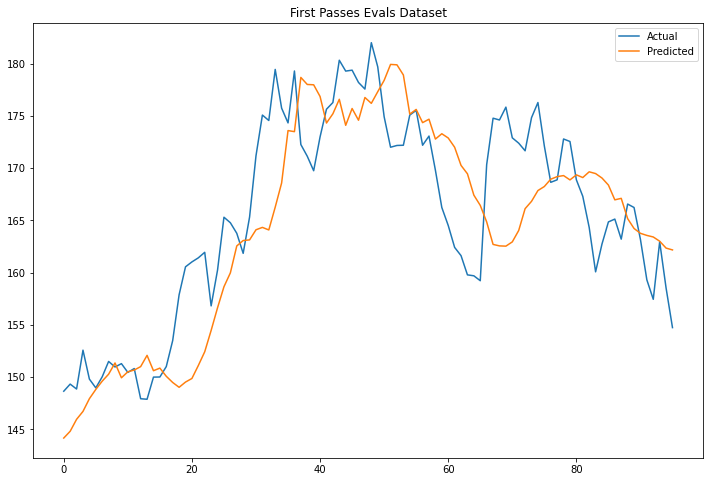

In [7]:
#//***** 128 Layers 20 EPOCHS -- LB 10
print("Run Time: ", total_time, "s")
print("Total Models: ", max_loop)
print(mp)
plt.figure(figsize=(12,8))

plt.plot(actuals, label="Actual")
plt.plot(predictions, label="Predicted")
plt.legend()
plt.title("First Passes Evals Dataset")

Run Time:  69 s
Total Models:  31
{'size': 30, 'lb': 10, 'layers': 128, 'epochs': 20, 'months_to_model': 3}


Text(0.5, 1.0, 'First Passes Evals Dataset')

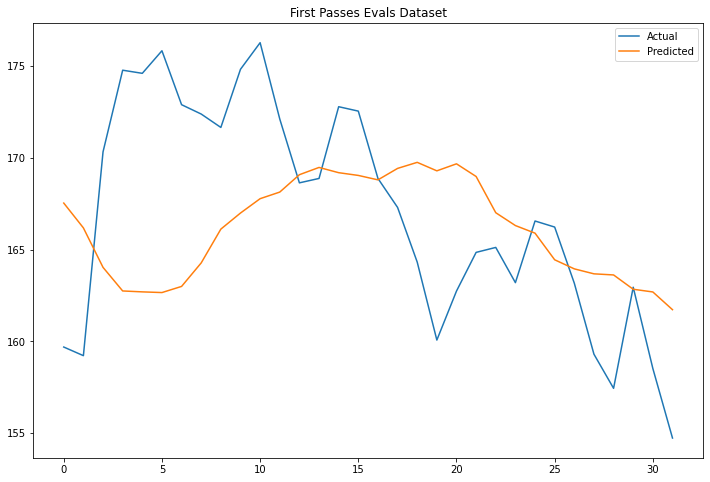

In [9]:
#//***** 128 Layers 20 EPOCHS -- LB 10
print("Run Time: ", total_time, "s")
print("Total Models: ", max_loop)
print(mp)
plt.figure(figsize=(12,8))

plt.plot(actuals, label="Actual")
plt.plot(predictions, label="Predicted")
plt.legend()
plt.title("First Passes Evals Dataset")

Run Time:  73 s
Total Models:  31
{'size': 30, 'lb': 10, 'layers': 128, 'epochs': 50, 'months_to_model': 3}


Text(0.5, 1.0, 'First Passes Evals Dataset')

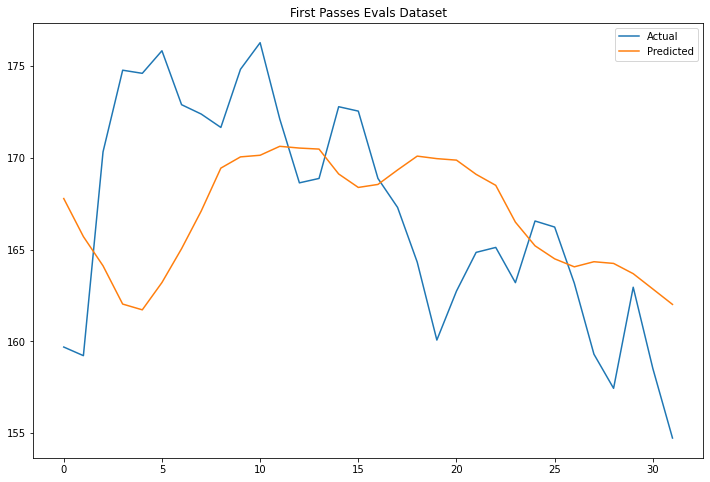

In [11]:
#//***** 128 Layers 50 EPOCHS -- LB 10
print("Run Time: ", total_time, "s")
print("Total Models: ", max_loop)
print(mp)
plt.figure(figsize=(12,8))

plt.plot(actuals, label="Actual")
plt.plot(predictions, label="Predicted")
plt.legend()
plt.title("First Passes Evals Dataset")

Run Time:  101 s
Total Models:  31
{'size': 30, 'lb': 10, 'layers': 128, 'epochs': 300, 'months_to_model': 3}


Text(0.5, 1.0, 'First Passes Evals Dataset')

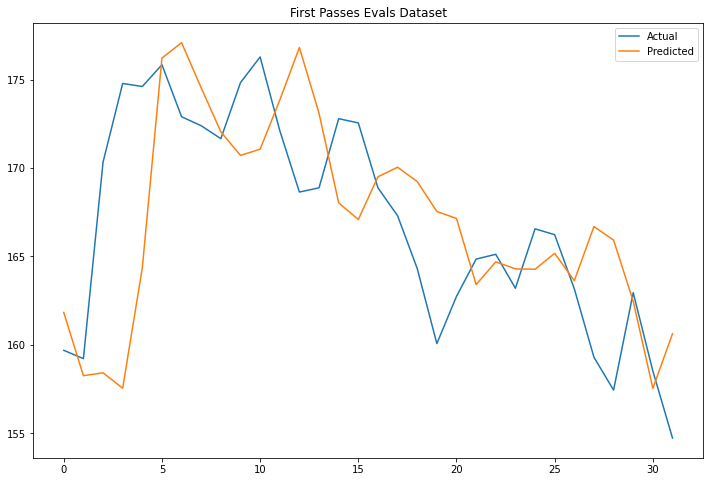

In [18]:
#//***** 128 Layers 300 EPOCHS <-----
print("Run Time: ", total_time, "s")
print("Total Models: ", max_loop)
print(mp)
plt.figure(figsize=(12,8))

plt.plot(actuals, label="Actual")
plt.plot(predictions, label="Predicted")
plt.legend()
plt.title("First Passes Evals Dataset")

Run Time:  78 s
Total Models:  31
{'size': 30, 'lb': 10, 'layers': 128, 'epochs': 100, 'months_to_model': 3}


Text(0.5, 1.0, 'First Passes Evals Dataset')

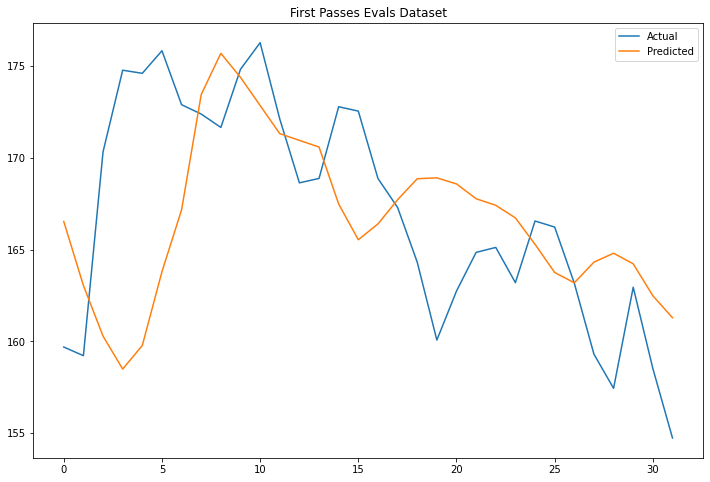

In [20]:
#//***** 128 Layers 100 EPOCHS
print("Run Time: ", total_time, "s")
print("Total Models: ", max_loop)
print(mp)
plt.figure(figsize=(12,8))

plt.plot(actuals, label="Actual")
plt.plot(predictions, label="Predicted")
plt.legend()
plt.title("First Passes Evals Dataset")

Run Time:  93 s
Total Models:  31
{'size': 30, 'lb': 10, 'layers': 256, 'epochs': 100, 'months_to_model': 3}


Text(0.5, 1.0, 'First Passes Evals Dataset')

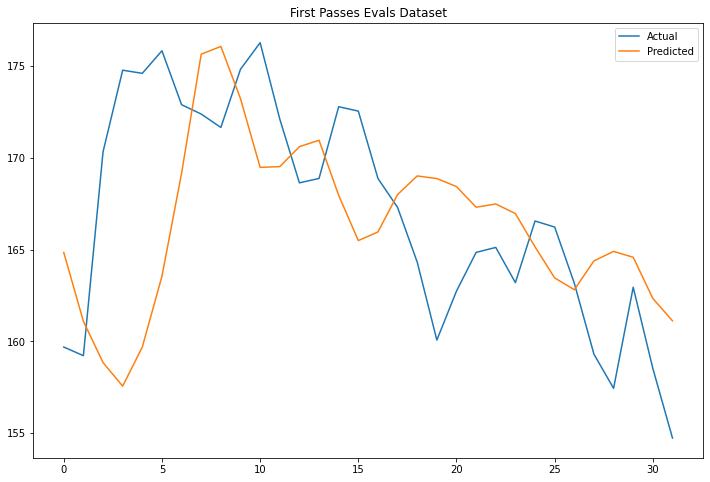

In [22]:
#//***** 256 Layers 100 EPOCHS -- LB 10
print("Run Time: ", total_time, "s")
print("Total Models: ", max_loop)
print(mp)
plt.figure(figsize=(12,8))

plt.plot(actuals, label="Actual")
plt.plot(predictions, label="Predicted")
plt.legend()
plt.title("First Passes Evals Dataset")

Run Time:  142 s
Total Models:  31
{'size': 30, 'lb': 10, 'layers': 512, 'epochs': 100, 'months_to_model': 3}


Text(0.5, 1.0, 'First Passes Evals Dataset')

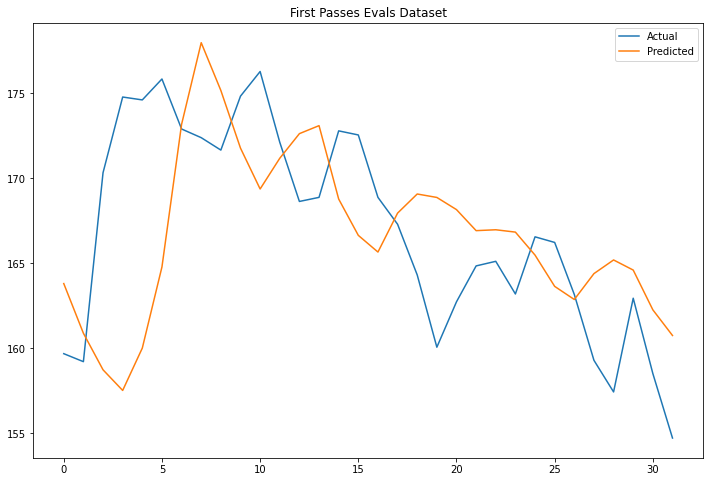

In [24]:
#//***** 512 Layers 100 EPOCHS -- LB 10
print("Run Time: ", total_time, "s")
print("Total Models: ", max_loop)
print(mp)
plt.figure(figsize=(12,8))

plt.plot(actuals, label="Actual")
plt.plot(predictions, label="Predicted")
plt.legend()
plt.title("First Passes Evals Dataset")

Run Time:  108 s
Total Models:  31
{'size': 30, 'lb': 20, 'layers': 256, 'epochs': 100, 'months_to_model': 3}


Text(0.5, 1.0, 'First Passes Evals Dataset')

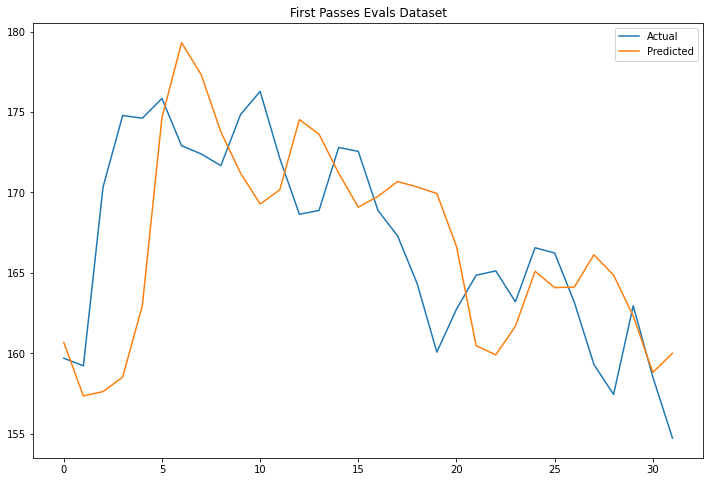

In [30]:
#//***** 256 Layers 100 EPOCHS -- LB 20
print("Run Time: ", total_time, "s")
print("Total Models: ", max_loop)
print(mp)
plt.figure(figsize=(12,8))

plt.plot(actuals, label="Actual")
plt.plot(predictions, label="Predicted")
plt.legend()
plt.title("First Passes Evals Dataset")

Run Time:  76 s
Total Models:  31
{'size': 30, 'lb': 5, 'layers': 128, 'epochs': 100, 'months_to_model': 3}


Text(0.5, 1.0, 'First Passes Evals Dataset')

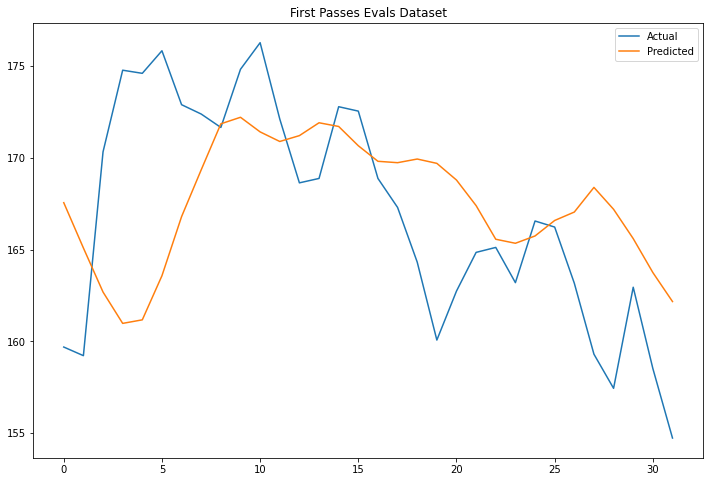

In [28]:
#//***** 128 Layers 100 EPOCHS -- LB 5
print("Run Time: ", total_time, "s")
print("Total Models: ", max_loop)
print(mp)
plt.figure(figsize=(12,8))

plt.plot(actuals, label="Actual")
plt.plot(predictions, label="Predicted")
plt.legend()
plt.title("First Passes Evals Dataset")

Run Time:  115 s
Total Models:  31
{'size': 30, 'lb': 5, 'layers': 512, 'epochs': 100, 'months_to_model': 3}


Text(0.5, 1.0, 'First Passes Evals Dataset')

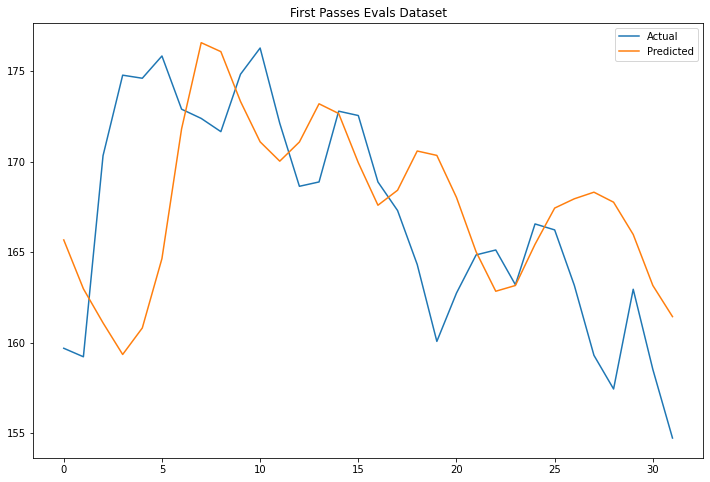

In [26]:
#//***** 512 Layers 100 EPOCHS -- LB 5
print("Run Time: ", total_time, "s")
print("Total Models: ", max_loop)
print(mp)
plt.figure(figsize=(12,8))

plt.plot(actuals, label="Actual")
plt.plot(predictions, label="Predicted")
plt.legend()
plt.title("First Passes Evals Dataset")

Run Time:  237 s
Total Models:  95
{'size': 30, 'lb': 10, 'layers': 256, 'epochs': 20, 'months_to_model': 6}


Text(0.5, 1.0, 'First Passes Evals Dataset')

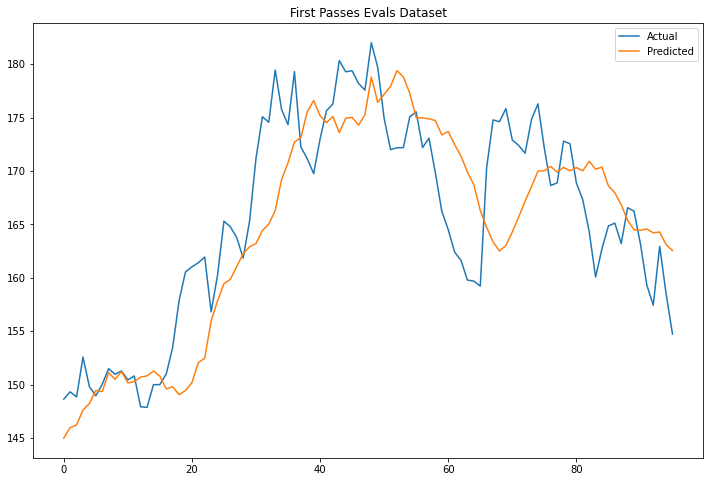

In [34]:
print("Run Time: ", total_time, "s")
print("Total Models: ", max_loop)
print(mp)
plt.figure(figsize=(12,8))

plt.plot(actuals, label="Actual")
plt.plot(predictions, label="Predicted")
plt.legend()
plt.title("First Passes Evals Dataset")

Run Time:  241 s
Total Models:  110
{'size': 15, 'lb': 10, 'layers': 64, 'epochs': 20, 'months_to_model': 6}


Text(0.5, 1.0, 'First Passes Evals Dataset')

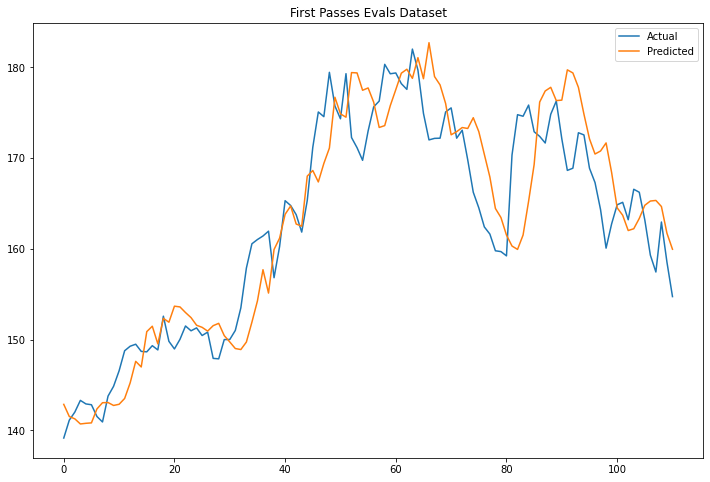

In [40]:
print("Run Time: ", total_time, "s")
print("Total Models: ", max_loop)
print(mp)
plt.figure(figsize=(12,8))

plt.plot(actuals, label="Actual")
plt.plot(predictions, label="Predicted")
plt.legend()
plt.title("First Passes Evals Dataset")

Run Time:  246 s
Total Models:  110
{'size': 15, 'lb': 10, 'layers': 128, 'epochs': 20, 'months_to_model': 6}


Text(0.5, 1.0, 'First Passes Evals Dataset')

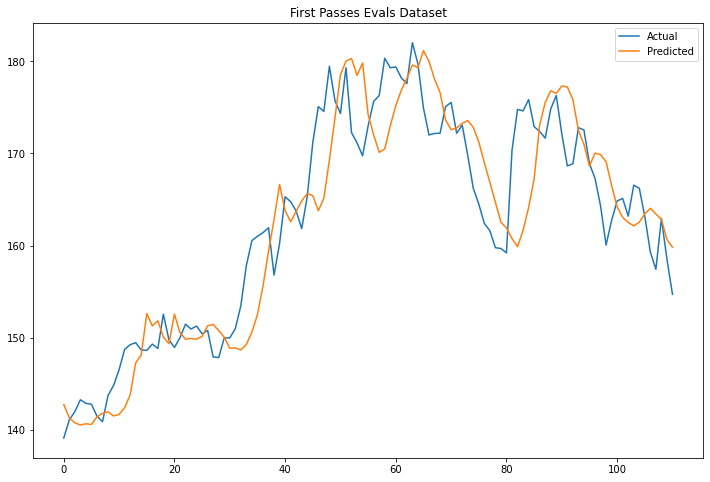

In [38]:
print("Run Time: ", total_time, "s")
print("Total Models: ", max_loop)
print(mp)
plt.figure(figsize=(12,8))

plt.plot(actuals, label="Actual")
plt.plot(predictions, label="Predicted")
plt.legend()
plt.title("First Passes Evals Dataset")

Run Time:  264 s
Total Models:  110
{'size': 15, 'lb': 10, 'layers': 256, 'epochs': 20, 'months_to_model': 6}


Text(0.5, 1.0, 'First Passes Evals Dataset')

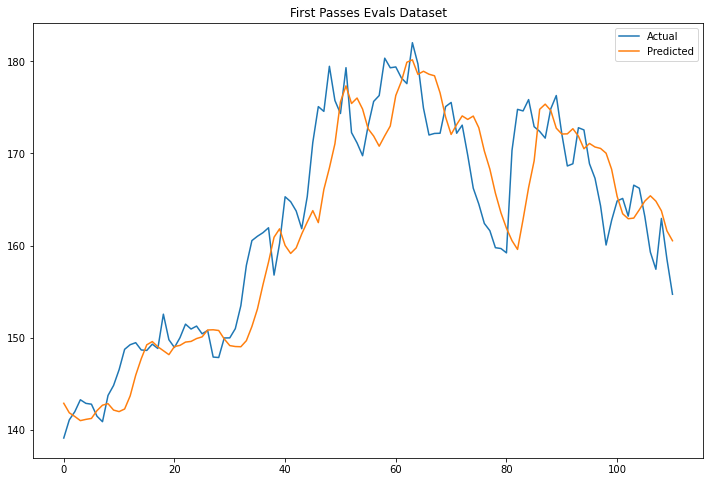

In [36]:
print("Run Time: ", total_time, "s")
print("Total Models: ", max_loop)
print(mp)
plt.figure(figsize=(12,8))

plt.plot(actuals, label="Actual")
plt.plot(predictions, label="Predicted")
plt.legend()
plt.title("First Passes Evals Dataset")

Run Time:  163 s
Total Models:  65
{'size': 60, 'lb': 10, 'layers': 256, 'epochs': 20, 'months_to_model': 6}


Text(0.5, 1.0, 'First Passes Evals Dataset')

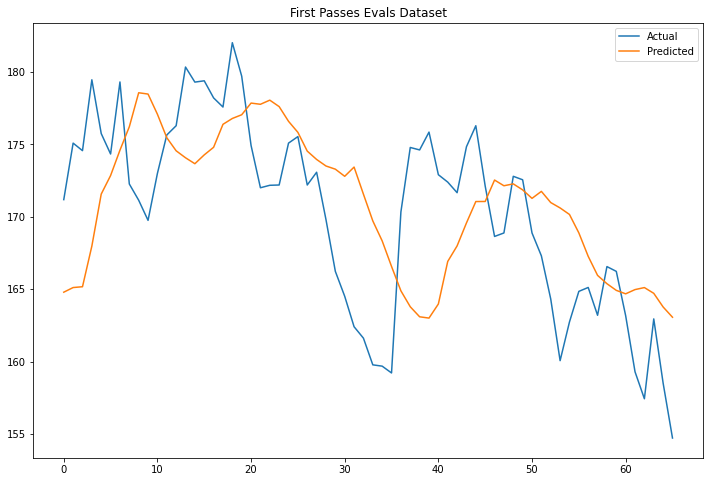

In [28]:
print("Run Time: ", total_time, "s")
print("Total Models: ", max_loop)
print(mp)
plt.figure(figsize=(12,8))

plt.plot(actuals, label="Actual")
plt.plot(predictions, label="Predicted")
plt.legend()
plt.title("First Passes Evals Dataset")

{'size': 60, 'lb': 10, 'layers': 256, 'epochs': 20, 'months_to_model': 12}


Text(0.5, 1.0, 'First Passes Evals Dataset')

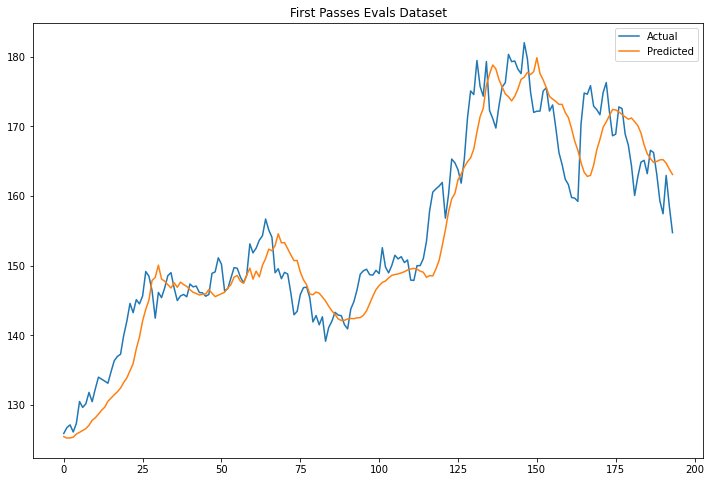

In [20]:
print(mp)
plt.figure(figsize=(12,8))

plt.plot(actuals, label="Actual")
plt.plot(predictions, label="Predicted")
plt.legend()
plt.title("First Passes Evals Dataset")

Text(0.5, 1.0, 'First Passes Evals Dataset')

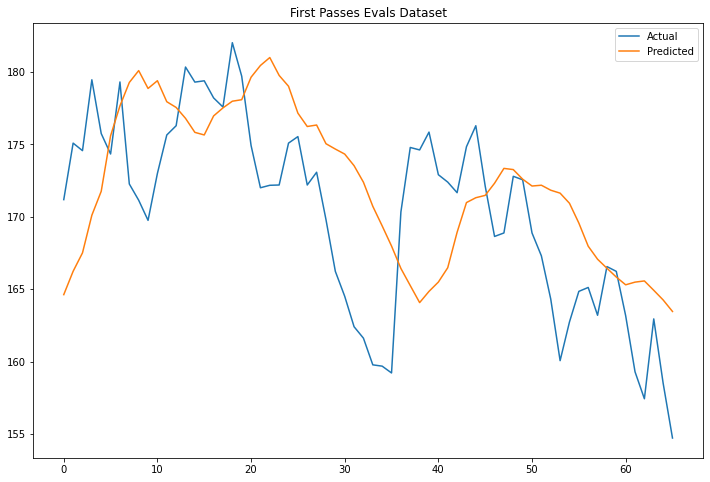

In [17]:
#128 layers, 30 epoch 30 dasy
plt.figure(figsize=(12,8))

plt.plot(actuals, label="Actual")
plt.plot(predictions, label="Predicted")
plt.legend()
plt.title("First Passes Evals Dataset")

In [71]:





#//*** Last Value in Data Set - Used to evaluate the prediction
y_test = cl.iloc[-1]

x_train = cl.iloc[-51:-1]

print("== CL ==")
print("x_test",x_test)
print("y_test",y_test)
#print(cl)



#//*** Scale the Data between 0 and 1
scl = MinMaxScaler()

#//*** Scale and reshape the data. Each value is returned as a list within a list
cl = scl.fit_transform(cl.values.reshape(-1,1))
#cl = cl.values.reshape(-1,1)

#//*** Build Data for Lookback arrays
X_train,y_train = processData(cl,lb)

print("== X ==")
print(X_train)
print("== y ==")
print(y_train)

print(X_train.shape,y_train.shape)

#//*** Build the test value using the last element of X_train
x_test = X_train[-1]

x_test.shape
print(x_test.shape)
#//*** Remove the first element
x_test = np.delete(x_test,0)
#//*** Add the last element of y_train, as our predict ahead
x_test = np.append(x_test,y_train[-1])



print(x_test.shape)

print(x_test.shape)
print(x_test)

"\n#//**** INTRA day EXTENDED provides stock data at intervals of 1min, 5min, 15min, 30min, 60min,\n#//**** Each query provides one month at a time\n\nimport csv\nCSV_URL = f'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY_EXTENDED&symbol={symbol}&interval=15min&slice=year1month1&apikey={av_apikey}'\n\nwith requests.Session() as s:\n    download = s.get(url)\n    decoded_content = download.content.decode('utf-8')\n    cr = csv.reader(decoded_content.splitlines(), delimiter=',')\n    my_list = list(cr)\n    for row in my_list:\n        print(row)\n"